In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=124.5, y1=127.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 302
Page 1, Q1, A: Yellow percentage: 0.0%


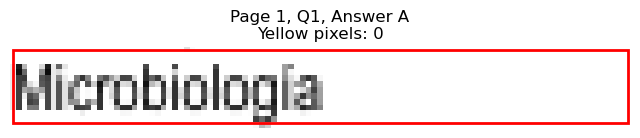

Page 1, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=116.9, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 234
Page 1, Q1, B: Yellow percentage: 0.0%


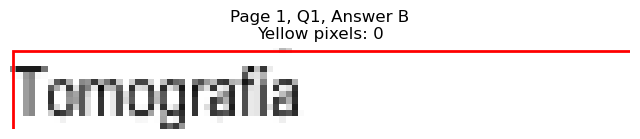

Page 1, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=368.7, y1=127.3
Page 1, Q1, C: Yellow pixels: 92
Page 1, Q1, C: Total non-white pixels: 310
Page 1, Q1, C: Yellow percentage: 29.7%


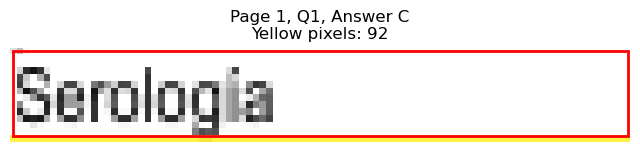

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=376.7, y1=139.9
Page 1, Q1, D: Yellow pixels: 1076
Page 1, Q1, D: Total non-white pixels: 1300
Page 1, Q1, D: Yellow percentage: 82.8%


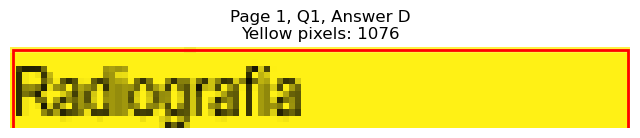


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=99.9, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 234
Page 1, Q2, A: Yellow percentage: 0.0%


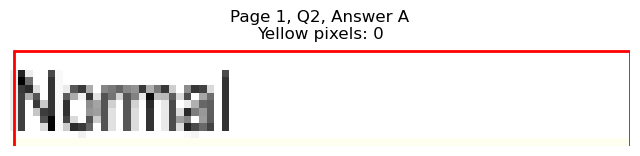

Page 1, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=116.4, y1=215.6
Page 1, Q2, B: Yellow pixels: 1103
Page 1, Q2, B: Total non-white pixels: 1386
Page 1, Q2, B: Yellow percentage: 79.6%


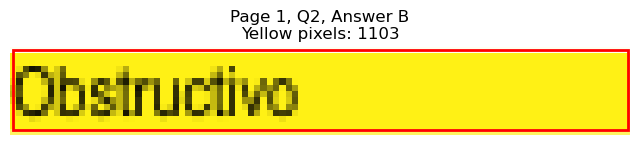

Page 1, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=372.2, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 238
Page 1, Q2, C: Yellow percentage: 0.0%


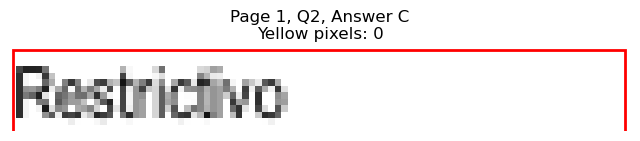

Page 1, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=351.7, y1=215.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 126
Page 1, Q2, D: Yellow percentage: 0.0%


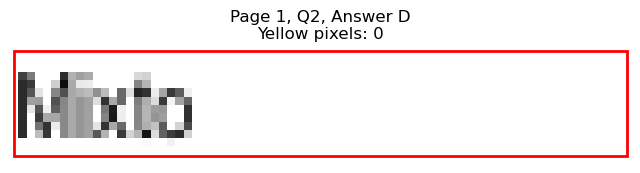


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=99.4, y1=278.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 158
Page 1, Q3, A: Yellow percentage: 0.0%


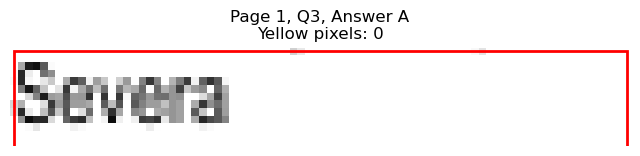

Page 1, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=111.4, y1=291.5
Page 1, Q3, B: Yellow pixels: 1030
Page 1, Q3, B: Total non-white pixels: 1316
Page 1, Q3, B: Yellow percentage: 78.3%


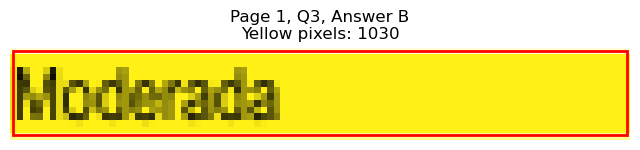

Page 1, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=354.7, y1=278.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 121
Page 1, Q3, C: Yellow percentage: 0.0%


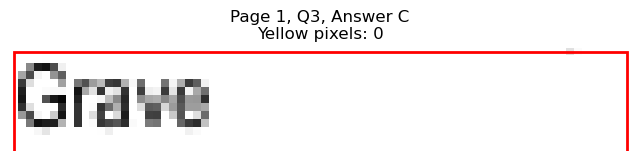

Page 1, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=349.6, y1=291.5
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 91
Page 1, Q3, D: Yellow percentage: 0.0%


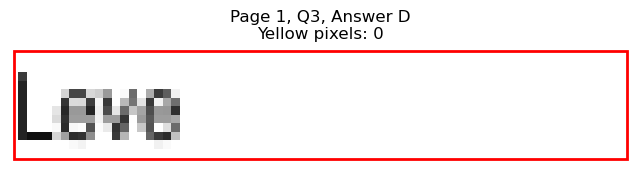


Page 1, Q3 - Selected Answer: B (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=195.3, y1=354.6
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 630
Page 1, Q4, A: Yellow percentage: 0.0%


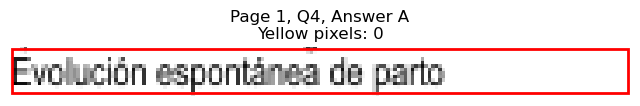

Page 1, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=178.1, y1=367.2
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 526
Page 1, Q4, B: Yellow percentage: 0.0%


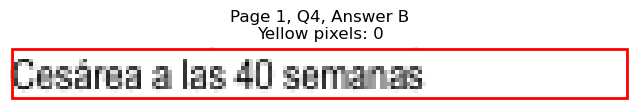

Page 1, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=416.8, y1=354.6
Page 1, Q4, C: Yellow pixels: 1483
Page 1, Q4, C: Total non-white pixels: 1960
Page 1, Q4, C: Yellow percentage: 75.7%


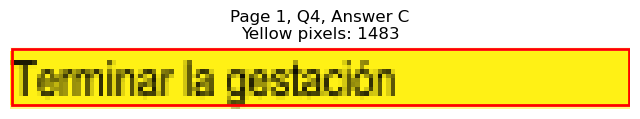

Page 1, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=473.5, y1=367.2
Page 1, Q4, D: Yellow pixels: 195
Page 1, Q4, D: Total non-white pixels: 896
Page 1, Q4, D: Yellow percentage: 21.8%


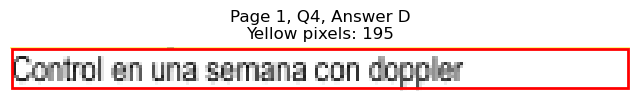


Page 1, Q4 - Selected Answer: C (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=275.0, y1=417.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 1040
Page 1, Q5, A: Yellow percentage: 0.0%


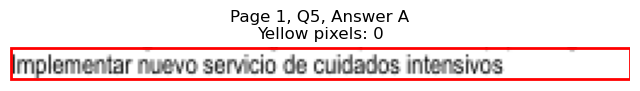

Page 1, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=303.6, y1=430.3
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 1112
Page 1, Q5, B: Yellow percentage: 0.0%


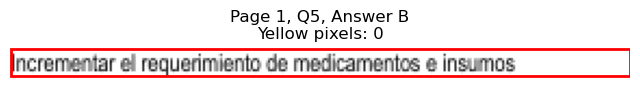

Page 1, Q5 - C: Detected box: x0=68.8, y0=430.2, x1=245.4, y1=442.9
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 1144
Page 1, Q5, C: Yellow percentage: 0.0%


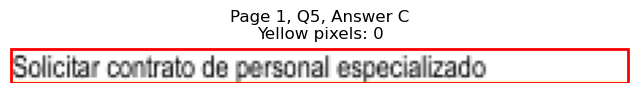

Page 1, Q5 - D: Detected box: x0=68.8, y0=442.8, x1=283.0, y1=455.5
Page 1, Q5, D: Yellow pixels: 2601
Page 1, Q5, D: Total non-white pixels: 3724
Page 1, Q5, D: Yellow percentage: 69.8%


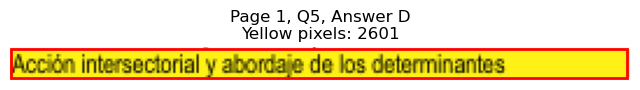


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=200.8, y1=506.0
Page 1, Q6, A: Yellow pixels: 1850
Page 1, Q6, A: Total non-white pixels: 2387
Page 1, Q6, A: Yellow percentage: 77.5%


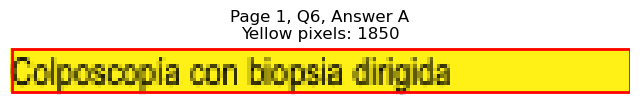

Page 1, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=178.7, y1=518.6
Page 1, Q6, B: Yellow pixels: 152
Page 1, Q6, B: Total non-white pixels: 691
Page 1, Q6, B: Yellow percentage: 22.0%


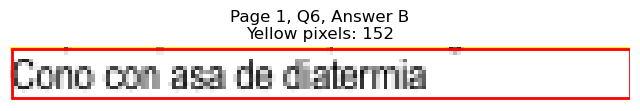

Page 1, Q6 - C: Detected box: x0=327.5, y0=493.4, x1=443.9, y1=506.0
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 625
Page 1, Q6, C: Yellow percentage: 0.0%


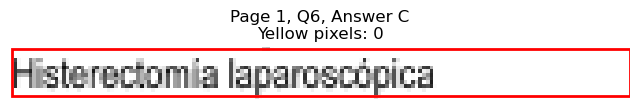

Page 1, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=428.8, y1=518.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 498
Page 1, Q6, D: Yellow percentage: 0.0%


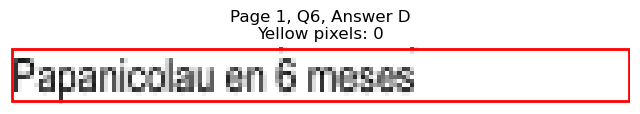


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=115.0, y1=581.8
Page 1, Q7, A: Yellow pixels: 1107
Page 1, Q7, A: Total non-white pixels: 1261
Page 1, Q7, A: Yellow percentage: 87.8%


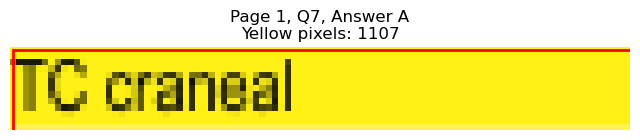

Page 1, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=127.9, y1=594.4
Page 1, Q7, B: Yellow pixels: 110
Page 1, Q7, B: Total non-white pixels: 430
Page 1, Q7, B: Yellow percentage: 25.6%


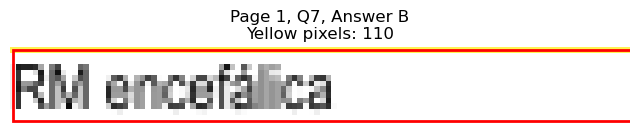

Page 1, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=406.3, y1=581.8
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 368
Page 1, Q7, C: Yellow percentage: 0.0%


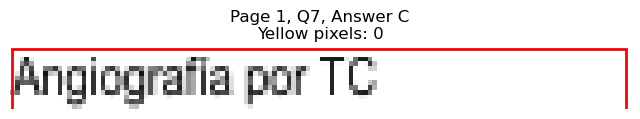

Page 1, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=408.3, y1=594.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 415
Page 1, Q7, D: Yellow percentage: 0.0%


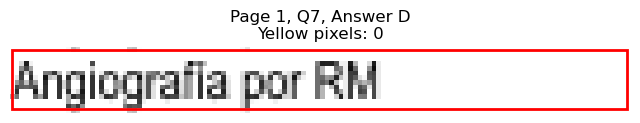


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=103.9, y1=632.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 190
Page 1, Q8, A: Yellow percentage: 0.0%


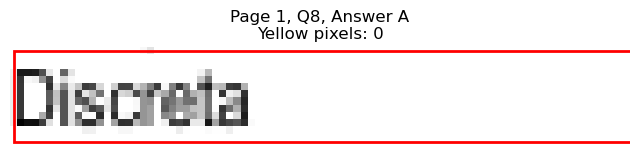

Page 1, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=99.9, y1=644.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 137
Page 1, Q8, B: Yellow percentage: 0.0%


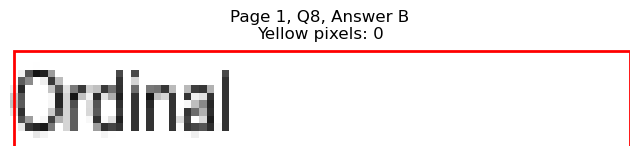

Page 1, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=387.3, y1=632.3
Page 1, Q8, C: Yellow pixels: 1061
Page 1, Q8, C: Total non-white pixels: 1554
Page 1, Q8, C: Yellow percentage: 68.3%


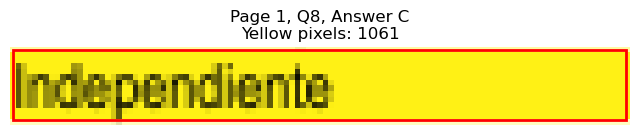

Page 1, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=381.2, y1=644.9
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 392
Page 1, Q8, D: Yellow percentage: 0.0%


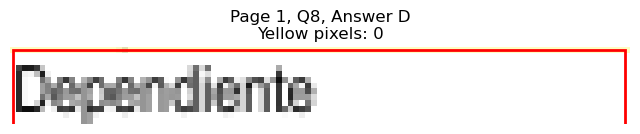


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=173.1, y1=708.0
Page 1, Q9, A: Yellow pixels: 156
Page 1, Q9, A: Total non-white pixels: 844
Page 1, Q9, A: Yellow percentage: 18.5%


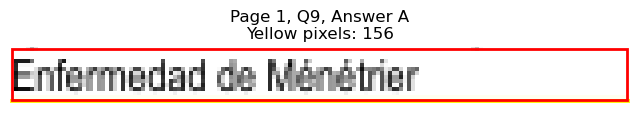

Page 1, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=150.1, y1=720.6
Page 1, Q9, B: Yellow pixels: 1429
Page 1, Q9, B: Total non-white pixels: 1862
Page 1, Q9, B: Yellow percentage: 76.7%


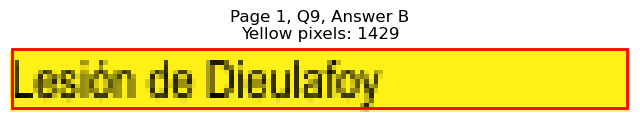

Page 1, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=423.3, y1=708.0
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 490
Page 1, Q9, C: Yellow percentage: 0.0%


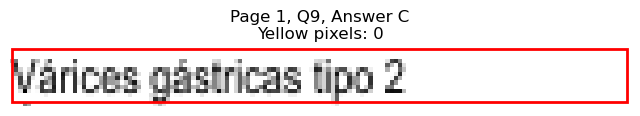

Page 1, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=419.4, y1=720.6
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 513
Page 1, Q9, D: Yellow percentage: 0.0%


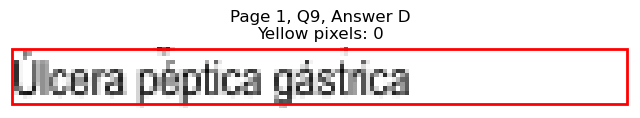


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=120.5, y1=127.3
Page 2, Q1, A: Yellow pixels: 103
Page 2, Q1, A: Total non-white pixels: 368
Page 2, Q1, A: Yellow percentage: 28.0%


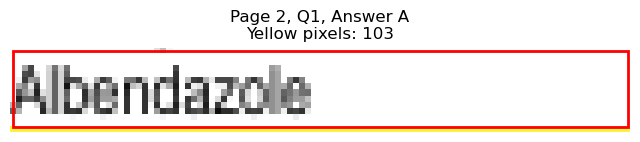

Page 2, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=117.5, y1=139.9
Page 2, Q1, B: Yellow pixels: 1103
Page 2, Q1, B: Total non-white pixels: 1300
Page 2, Q1, B: Yellow percentage: 84.8%


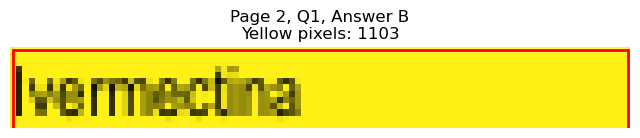

Page 2, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=410.8, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 419
Page 2, Q1, C: Yellow percentage: 0.0%


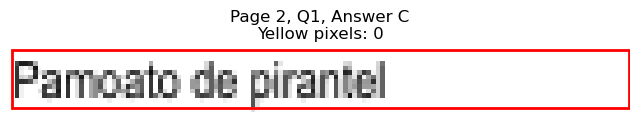

Page 2, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=379.3, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 279
Page 2, Q1, D: Yellow percentage: 0.0%


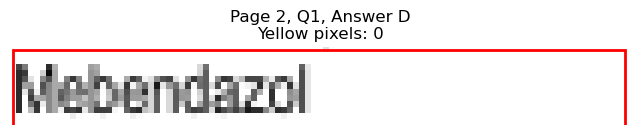


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=158.2, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 443
Page 2, Q2, A: Yellow percentage: 0.0%


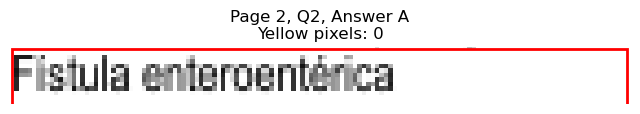

Page 2, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=145.0, y1=190.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 382
Page 2, Q2, B: Yellow percentage: 0.0%


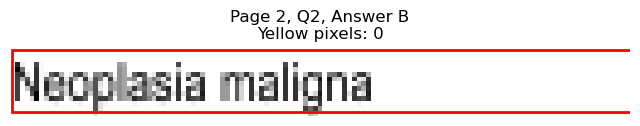

Page 2, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=400.3, y1=177.8
Page 2, Q2, C: Yellow pixels: 1322
Page 2, Q2, C: Total non-white pixels: 1612
Page 2, Q2, C: Yellow percentage: 82.0%


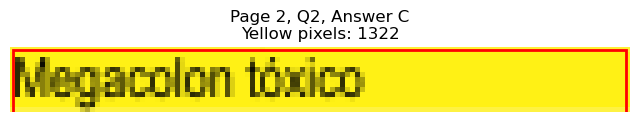

Page 2, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=389.8, y1=190.4
Page 2, Q2, D: Yellow pixels: 112
Page 2, Q2, D: Total non-white pixels: 440
Page 2, Q2, D: Yellow percentage: 25.5%


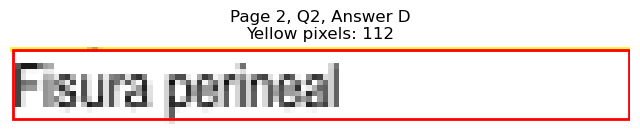


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=80.9, y1=240.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 123
Page 2, Q3, A: Yellow percentage: 0.0%


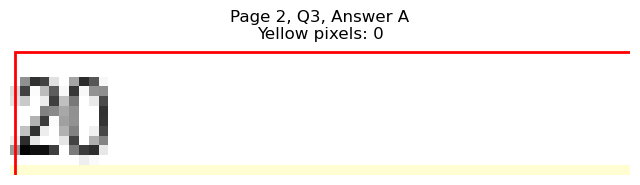

Page 2, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=80.9, y1=253.5
Page 2, Q3, B: Yellow pixels: 773
Page 2, Q3, B: Total non-white pixels: 882
Page 2, Q3, B: Yellow percentage: 87.6%


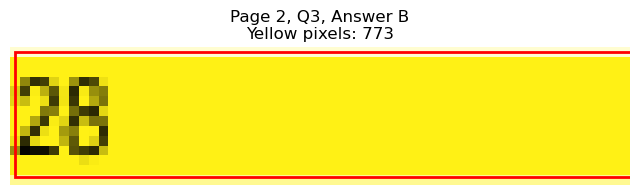

Page 2, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=340.1, y1=240.9
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 55
Page 2, Q3, C: Yellow percentage: 0.0%


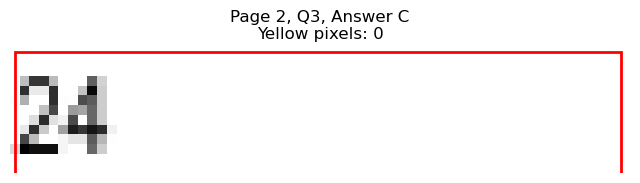

Page 2, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=340.1, y1=253.5
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 56
Page 2, Q3, D: Yellow percentage: 0.0%


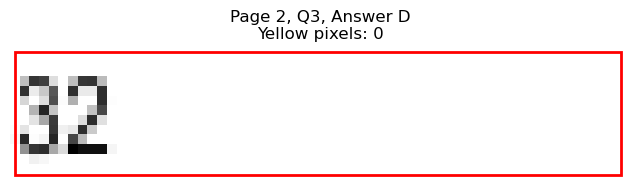


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=189.6, y1=316.7
Page 2, Q4, A: Yellow pixels: 1750
Page 2, Q4, A: Total non-white pixels: 2236
Page 2, Q4, A: Yellow percentage: 78.3%


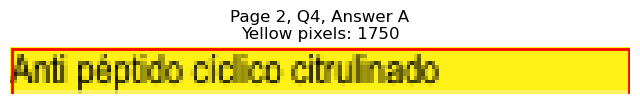

Page 2, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=149.1, y1=329.3
Page 2, Q4, B: Yellow pixels: 132
Page 2, Q4, B: Total non-white pixels: 516
Page 2, Q4, B: Yellow percentage: 25.6%


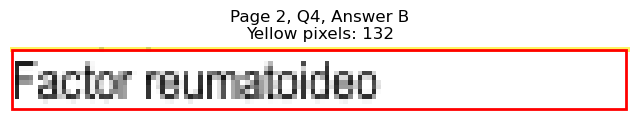

Page 2, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=407.3, y1=316.7
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 397
Page 2, Q4, C: Yellow percentage: 0.0%


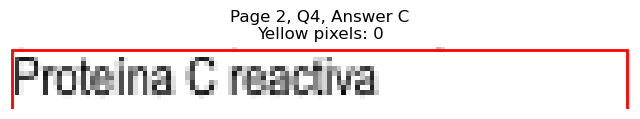

Page 2, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=418.9, y1=329.3
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 474
Page 2, Q4, D: Yellow percentage: 0.0%


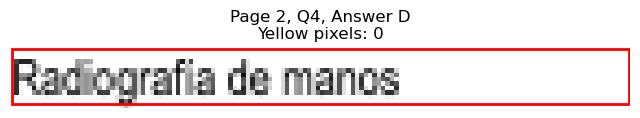


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=138.5, y1=367.2
Page 2, Q5, A: Yellow pixels: 1299
Page 2, Q5, A: Total non-white pixels: 1694
Page 2, Q5, A: Yellow percentage: 76.7%


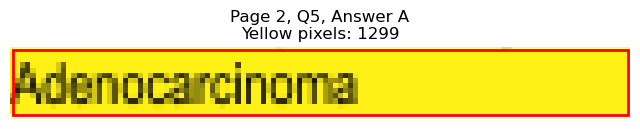

Page 2, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=137.1, y1=379.8
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 459
Page 2, Q5, B: Yellow percentage: 0.0%


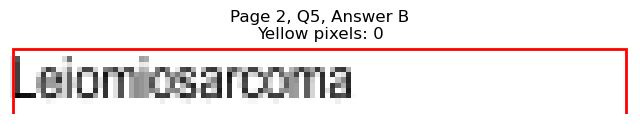

Page 2, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=362.2, y1=367.2
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 146
Page 2, Q5, C: Yellow percentage: 0.0%


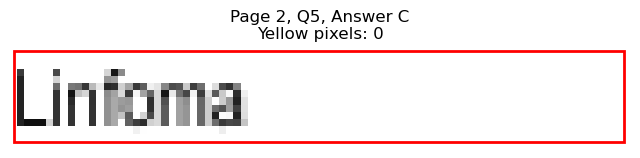

Page 2, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=394.3, y1=379.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 341
Page 2, Q5, D: Yellow percentage: 0.0%


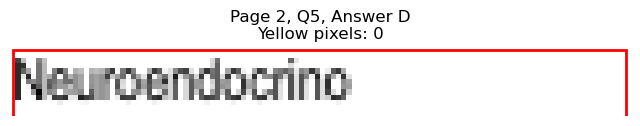


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=141.0, y1=442.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 518
Page 2, Q6, A: Yellow percentage: 0.0%


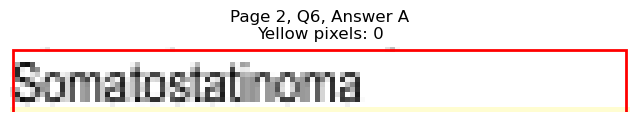

Page 2, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=114.5, y1=455.5
Page 2, Q6, B: Yellow pixels: 1105
Page 2, Q6, B: Total non-white pixels: 1358
Page 2, Q6, B: Yellow percentage: 81.4%


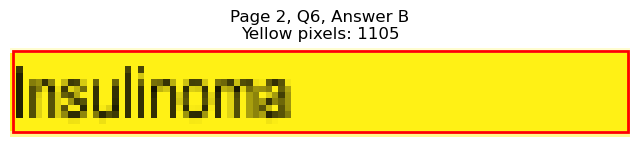

Page 2, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=376.7, y1=442.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 238
Page 2, Q6, C: Yellow percentage: 0.0%


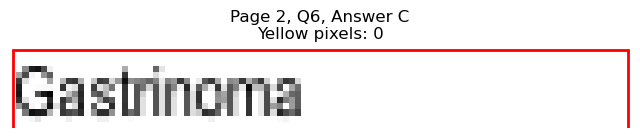

Page 2, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=386.2, y1=455.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 286
Page 2, Q6, D: Yellow percentage: 0.0%


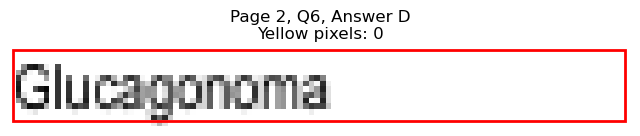


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=480.8, x1=150.0, y1=493.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 421
Page 2, Q7, A: Yellow percentage: 0.0%


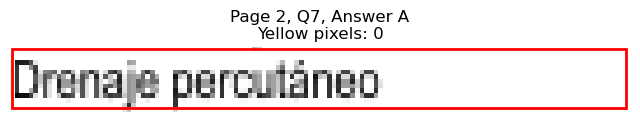

Page 2, Q7 - B: Detected box: x0=68.3, y0=493.4, x1=120.5, y1=506.0
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 294
Page 2, Q7, B: Yellow percentage: 0.0%


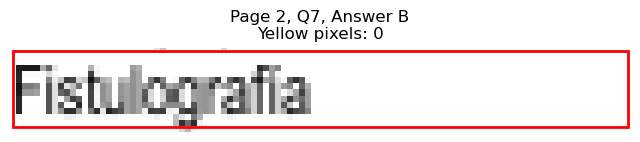

Page 2, Q7 - C: Detected box: x0=327.5, y0=480.8, x1=380.7, y1=493.4
Page 2, Q7, C: Yellow pixels: 1049
Page 2, Q7, C: Total non-white pixels: 1456
Page 2, Q7, C: Yellow percentage: 72.0%


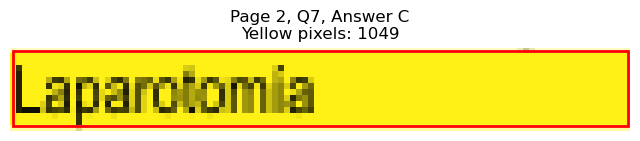

Page 2, Q7 - D: Detected box: x0=327.5, y0=493.4, x1=380.7, y1=506.0
Page 2, Q7, D: Yellow pixels: 1
Page 2, Q7, D: Total non-white pixels: 367
Page 2, Q7, D: Yellow percentage: 0.3%


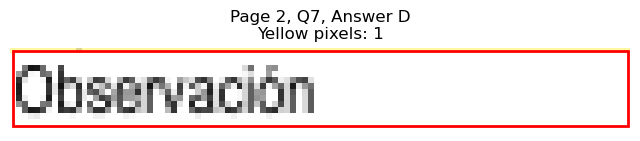


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=543.8, x1=108.4, y1=556.4
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 210
Page 2, Q8, A: Yellow percentage: 0.0%


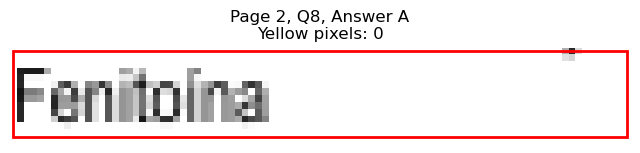

Page 2, Q8 - B: Detected box: x0=68.3, y0=556.5, x1=102.9, y1=569.2
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 178
Page 2, Q8, B: Yellow percentage: 0.0%


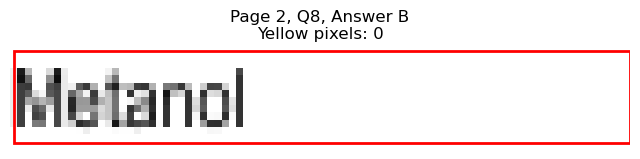

Page 2, Q8 - C: Detected box: x0=327.5, y0=543.8, x1=370.6, y1=556.4
Page 2, Q8, C: Yellow pixels: 1052
Page 2, Q8, C: Total non-white pixels: 1316
Page 2, Q8, C: Yellow percentage: 79.9%


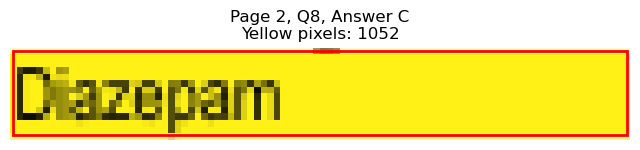

Page 2, Q8 - D: Detected box: x0=327.5, y0=556.5, x1=368.7, y1=569.2
Page 2, Q8, D: Yellow pixels: 92
Page 2, Q8, D: Total non-white pixels: 287
Page 2, Q8, D: Yellow percentage: 32.1%


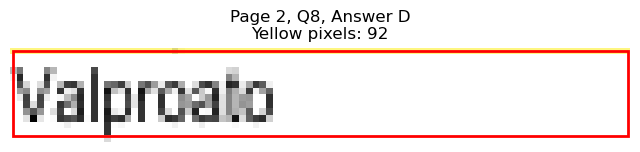


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=619.6, x1=135.0, y1=632.3
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 361
Page 2, Q9, A: Yellow percentage: 0.0%


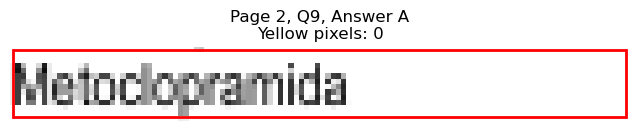

Page 2, Q9 - B: Detected box: x0=68.3, y0=632.2, x1=111.4, y1=644.9
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 231
Page 2, Q9, B: Yellow percentage: 0.0%


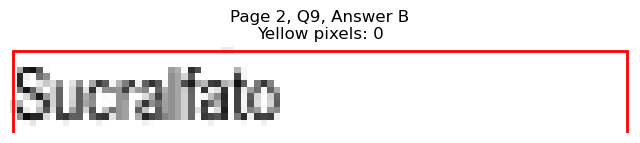

Page 2, Q9 - C: Detected box: x0=327.5, y0=619.6, x1=371.7, y1=632.3
Page 2, Q9, C: Yellow pixels: 959
Page 2, Q9, C: Total non-white pixels: 1330
Page 2, Q9, C: Yellow percentage: 72.1%


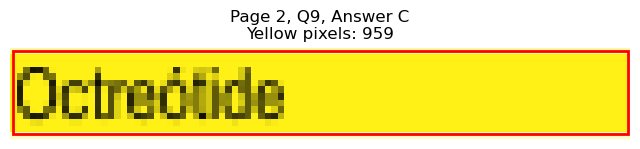

Page 2, Q9 - D: Detected box: x0=327.5, y0=632.2, x1=370.1, y1=644.9
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 334
Page 2, Q9, D: Yellow percentage: 0.0%


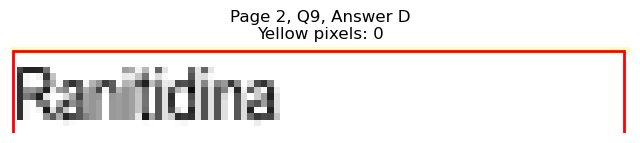


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=77.9, y0=682.7, x1=87.4, y1=695.3
Page 2, Q10, A: Yellow pixels: 682
Page 2, Q10, A: Total non-white pixels: 854
Page 2, Q10, A: Yellow percentage: 79.9%


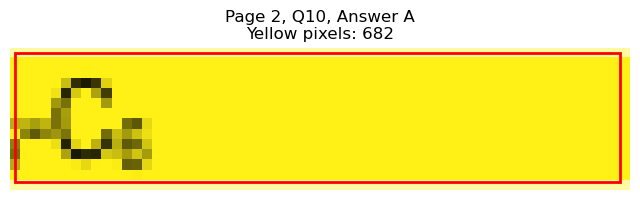

Page 2, Q10 - B: Detected box: x0=77.9, y0=695.4, x1=87.4, y1=708.0
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 118
Page 2, Q10, B: Yellow percentage: 0.0%


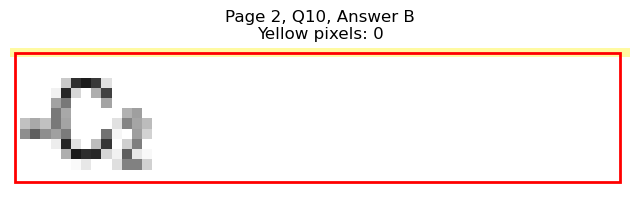

Page 2, Q10 - C: Detected box: x0=337.1, y0=682.7, x1=346.7, y1=695.3
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 52
Page 2, Q10, C: Yellow percentage: 0.0%


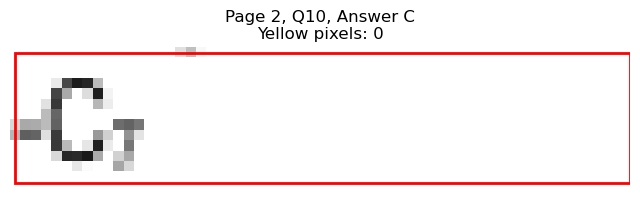

Page 2, Q10 - D: Detected box: x0=337.1, y0=695.4, x1=346.7, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 56
Page 2, Q10, D: Yellow percentage: 0.0%


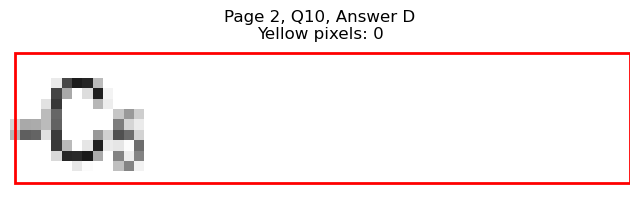


Page 2, Q10 - Selected Answer: A (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=141.5, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 385
Page 3, Q1, A: Yellow percentage: 0.0%


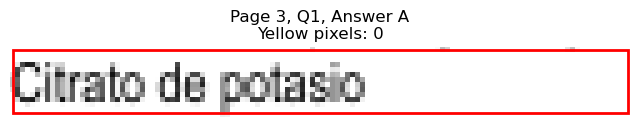

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=153.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 442
Page 3, Q1, B: Yellow percentage: 0.0%


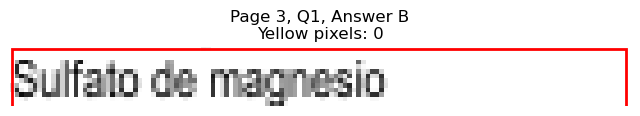

Page 3, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=414.8, y1=127.3
Page 3, Q1, C: Yellow pixels: 138
Page 3, Q1, C: Total non-white pixels: 570
Page 3, Q1, C: Yellow percentage: 24.2%


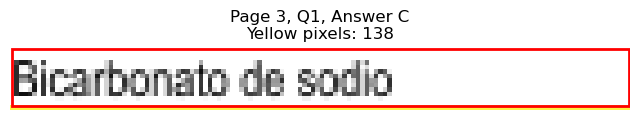

Page 3, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=409.3, y1=139.9
Page 3, Q1, D: Yellow pixels: 1434
Page 3, Q1, D: Total non-white pixels: 1729
Page 3, Q1, D: Yellow percentage: 82.9%


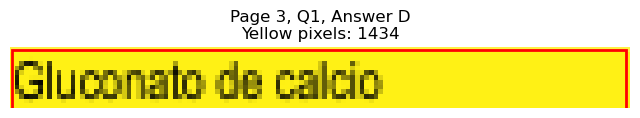


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=133.9, y1=215.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 345
Page 3, Q2, A: Yellow percentage: 0.0%


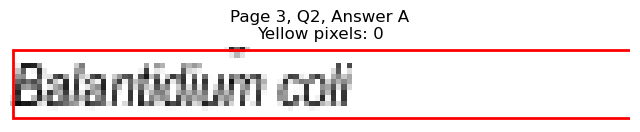

Page 3, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=142.5, y1=228.3
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 383
Page 3, Q2, B: Yellow percentage: 0.0%


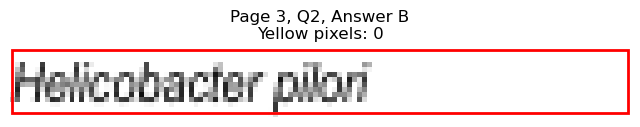

Page 3, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=390.2, y1=215.6
Page 3, Q2, C: Yellow pixels: 1220
Page 3, Q2, C: Total non-white pixels: 1596
Page 3, Q2, C: Yellow percentage: 76.4%


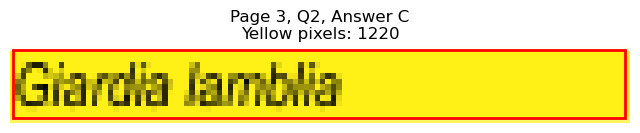

Page 3, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=402.8, y1=228.3
Page 3, Q2, D: Yellow pixels: 126
Page 3, Q2, D: Total non-white pixels: 509
Page 3, Q2, D: Yellow percentage: 24.8%


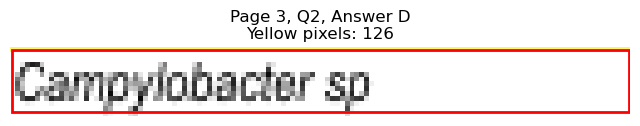


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=109.9, y1=266.1
Page 3, Q3, A: Yellow pixels: 1062
Page 3, Q3, A: Total non-white pixels: 1288
Page 3, Q3, A: Yellow percentage: 82.5%


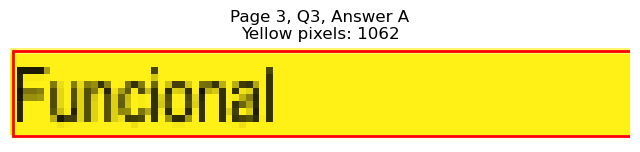

Page 3, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=110.9, y1=278.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 296
Page 3, Q3, B: Yellow percentage: 0.0%


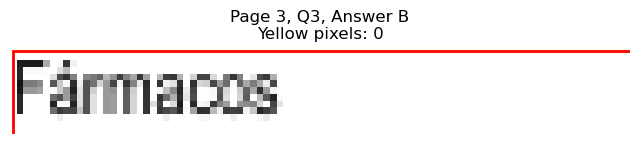

Page 3, Q3 - C: Detected box: x0=327.5, y0=253.5, x1=428.3, y1=266.1
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 515
Page 3, Q3, C: Yellow percentage: 0.0%


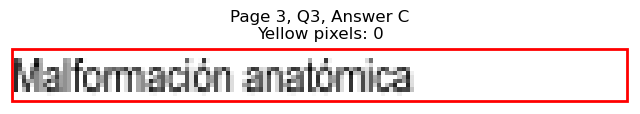

Page 3, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=366.7, y1=278.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 198
Page 3, Q3, D: Yellow percentage: 0.0%


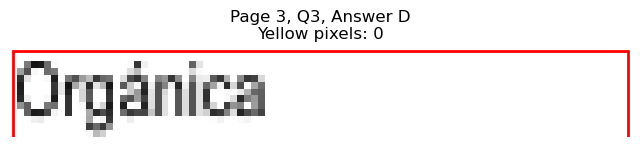


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=132.0, y1=341.9
Page 3, Q4, A: Yellow pixels: 1278
Page 3, Q4, A: Total non-white pixels: 1495
Page 3, Q4, A: Yellow percentage: 85.5%


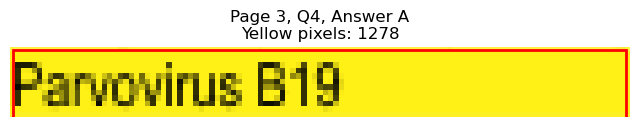

Page 3, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=127.9, y1=354.6
Page 3, Q4, B: Yellow pixels: 110
Page 3, Q4, B: Total non-white pixels: 414
Page 3, Q4, B: Yellow percentage: 26.6%


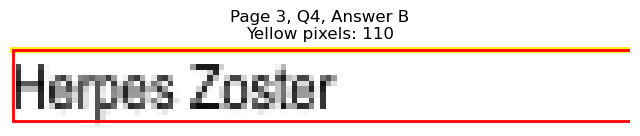

Page 3, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=388.3, y1=341.9
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 293
Page 3, Q4, C: Yellow percentage: 0.0%


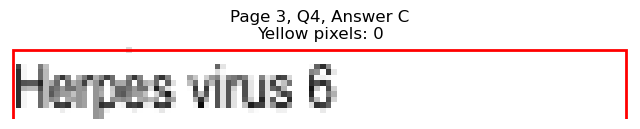

Page 3, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=387.2, y1=354.6
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 291
Page 3, Q4, D: Yellow percentage: 0.0%


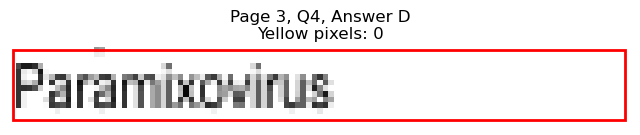


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=204.2, y1=417.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 641
Page 3, Q5, A: Yellow percentage: 0.0%


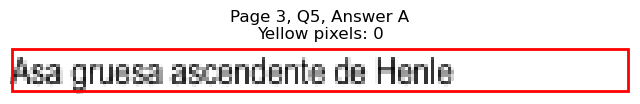

Page 3, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=110.4, y1=430.3
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 226
Page 3, Q5, B: Yellow percentage: 0.0%


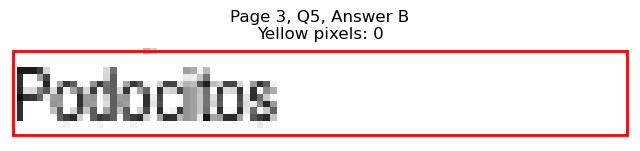

Page 3, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=442.4, y1=417.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 602
Page 3, Q5, C: Yellow percentage: 0.0%


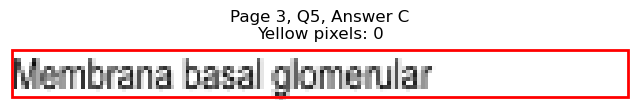

Page 3, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=391.7, y1=430.3
Page 3, Q5, D: Yellow pixels: 1119
Page 3, Q5, D: Total non-white pixels: 1610
Page 3, Q5, D: Yellow percentage: 69.5%


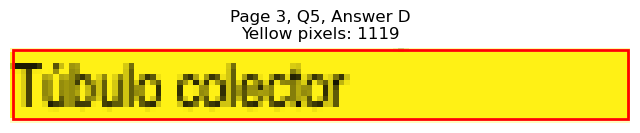


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=143.5, y1=506.0
Page 3, Q6, A: Yellow pixels: 126
Page 3, Q6, A: Total non-white pixels: 619
Page 3, Q6, A: Yellow percentage: 20.4%


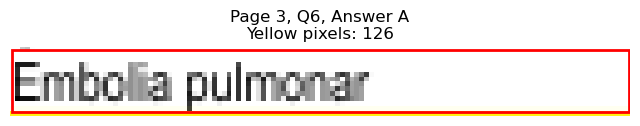

Page 3, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=134.5, y1=518.6
Page 3, Q6, B: Yellow pixels: 1251
Page 3, Q6, B: Total non-white pixels: 1638
Page 3, Q6, B: Yellow percentage: 76.4%


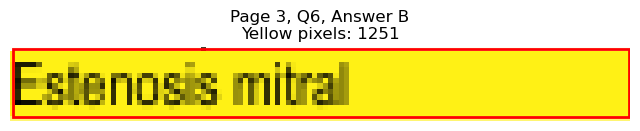

Page 3, Q6 - C: Detected box: x0=327.5, y0=493.4, x1=414.8, y1=506.0
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 432
Page 3, Q6, C: Yellow percentage: 0.0%


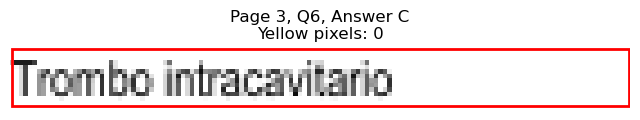

Page 3, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=392.2, y1=518.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 350
Page 3, Q6, D: Yellow percentage: 0.0%


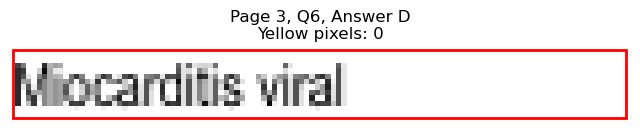


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=157.6, y1=556.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 449
Page 3, Q7, A: Yellow percentage: 0.0%


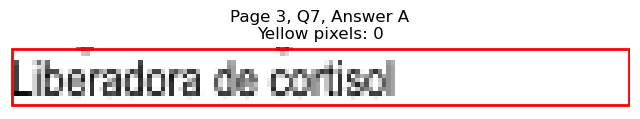

Page 3, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=204.2, y1=569.2
Page 3, Q7, B: Yellow pixels: 1893
Page 3, Q7, B: Total non-white pixels: 2618
Page 3, Q7, B: Yellow percentage: 72.3%


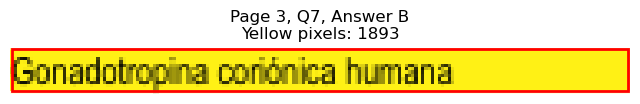

Page 3, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=390.2, y1=556.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 311
Page 3, Q7, C: Yellow percentage: 0.0%


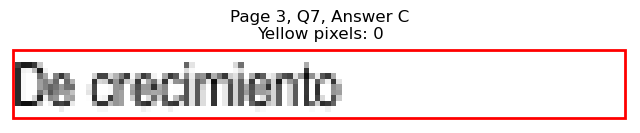

Page 3, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=379.7, y1=569.2
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 277
Page 3, Q7, D: Yellow percentage: 0.0%


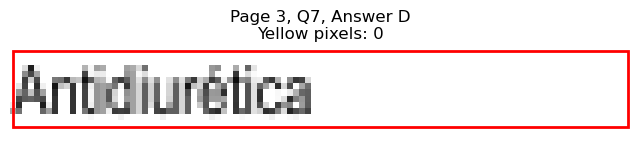


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=134.5, y1=644.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 459
Page 3, Q8, A: Yellow percentage: 0.0%


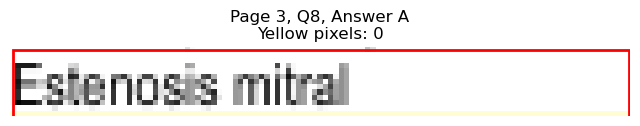

Page 3, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=150.0, y1=657.5
Page 3, Q8, B: Yellow pixels: 1427
Page 3, Q8, B: Total non-white pixels: 1862
Page 3, Q8, B: Yellow percentage: 76.6%


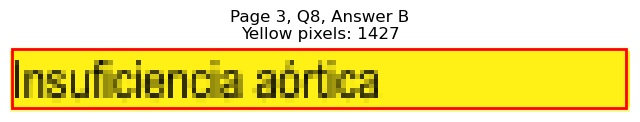

Page 3, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=398.8, y1=644.9
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 358
Page 3, Q8, C: Yellow percentage: 0.0%


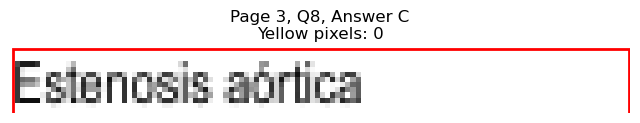

Page 3, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=404.2, y1=657.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 400
Page 3, Q8, D: Yellow percentage: 0.0%


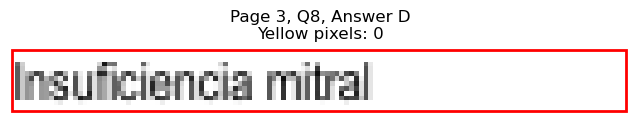


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=108.9, y1=720.6
Page 3, Q9, A: Yellow pixels: 91
Page 3, Q9, A: Total non-white pixels: 285
Page 3, Q9, A: Yellow percentage: 31.9%


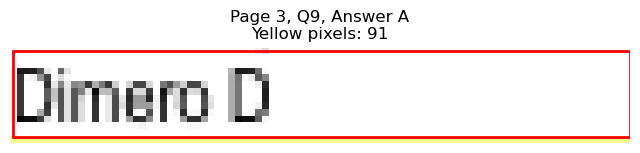

Page 3, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=205.2, y1=733.2
Page 3, Q9, B: Yellow pixels: 1903
Page 3, Q9, B: Total non-white pixels: 2632
Page 3, Q9, B: Yellow percentage: 72.3%


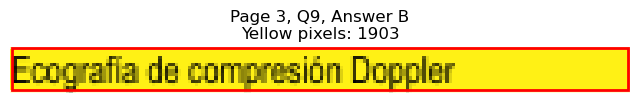

Page 3, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=430.9, y1=720.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 519
Page 3, Q9, C: Yellow percentage: 0.0%


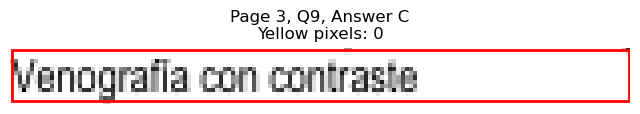

Page 3, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=396.3, y1=733.2
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 354
Page 3, Q9, D: Yellow percentage: 0.0%


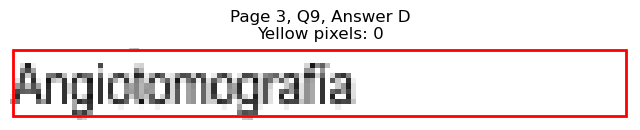


Page 3, Q9 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=127.9, y1=114.7
Page 4, Q1, A: Yellow pixels: 1
Page 4, Q1, A: Total non-white pixels: 407
Page 4, Q1, A: Yellow percentage: 0.2%


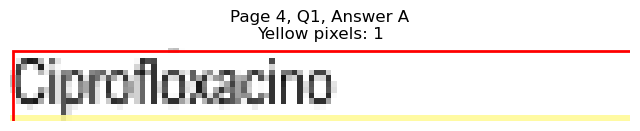

Page 4, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=158.1, y1=127.3
Page 4, Q1, B: Yellow pixels: 1312
Page 4, Q1, B: Total non-white pixels: 1974
Page 4, Q1, B: Yellow percentage: 66.5%


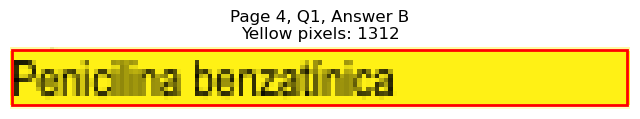

Page 4, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=376.1, y1=114.7
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 250
Page 4, Q1, C: Yellow percentage: 0.0%


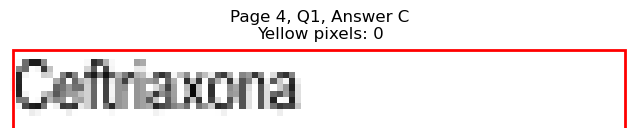

Page 4, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=375.7, y1=127.3
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 242
Page 4, Q1, D: Yellow percentage: 0.0%


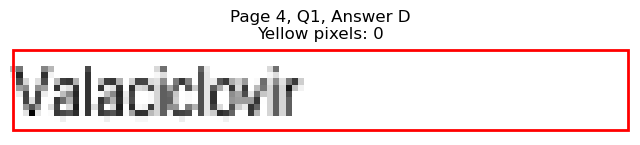


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=88.3, y1=177.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 171
Page 4, Q2, A: Yellow percentage: 0.0%


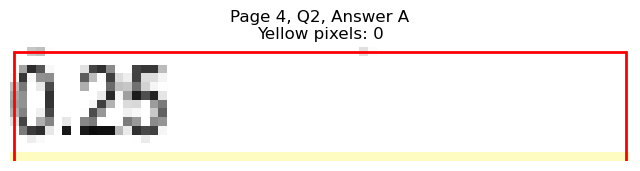

Page 4, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=83.4, y1=190.4
Page 4, Q2, B: Yellow pixels: 747
Page 4, Q2, B: Total non-white pixels: 924
Page 4, Q2, B: Yellow percentage: 80.8%


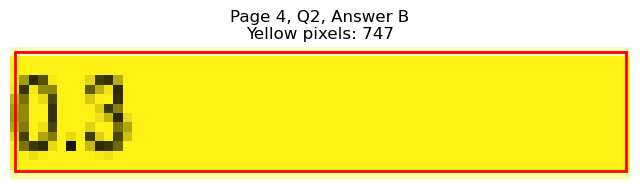

Page 4, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=342.7, y1=177.8
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 62
Page 4, Q2, C: Yellow percentage: 0.0%


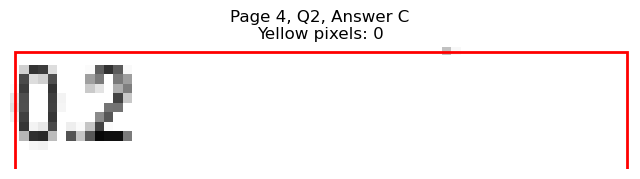

Page 4, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=347.6, y1=190.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 86
Page 4, Q2, D: Yellow percentage: 0.0%


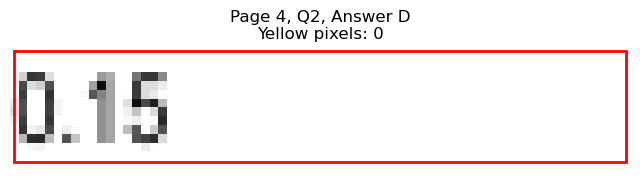


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=121.5, y1=240.9
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 278
Page 4, Q3, A: Yellow percentage: 0.0%


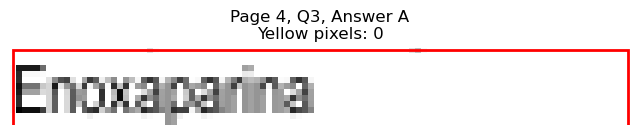

Page 4, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=109.9, y1=253.5
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 200
Page 4, Q3, B: Yellow percentage: 0.0%


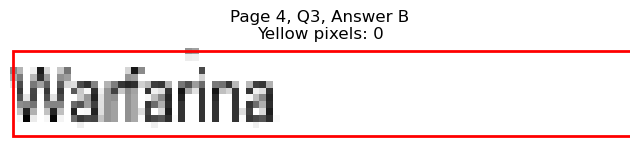

Page 4, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=428.3, y1=240.9
Page 4, Q3, C: Yellow pixels: 1597
Page 4, Q3, C: Total non-white pixels: 1976
Page 4, Q3, C: Yellow percentage: 80.8%


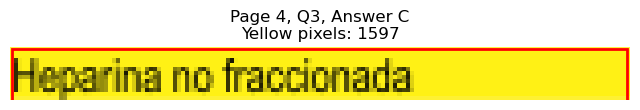

Page 4, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=373.7, y1=253.5
Page 4, Q3, D: Yellow pixels: 95
Page 4, Q3, D: Total non-white pixels: 321
Page 4, Q3, D: Yellow percentage: 29.6%


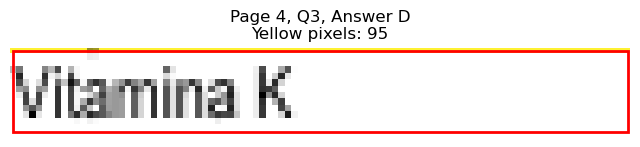


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=112.9, y1=316.7
Page 4, Q4, A: Yellow pixels: 1052
Page 4, Q4, A: Total non-white pixels: 1235
Page 4, Q4, A: Yellow percentage: 85.2%


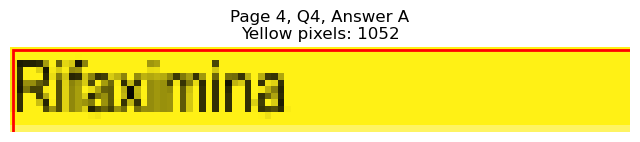

Page 4, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=119.9, y1=329.3
Page 4, Q4, B: Yellow pixels: 102
Page 4, Q4, B: Total non-white pixels: 350
Page 4, Q4, B: Yellow percentage: 29.1%


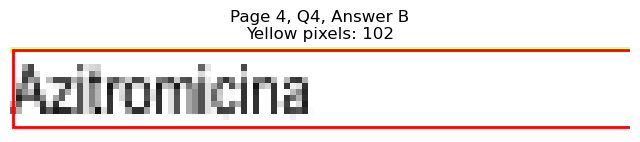

Page 4, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=387.2, y1=316.7
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 316
Page 4, Q4, C: Yellow percentage: 0.0%


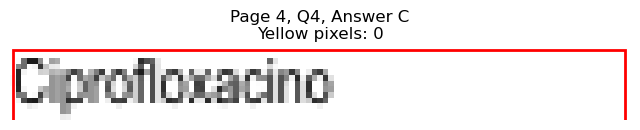

Page 4, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=375.7, y1=329.3
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 255
Page 4, Q4, D: Yellow percentage: 0.0%


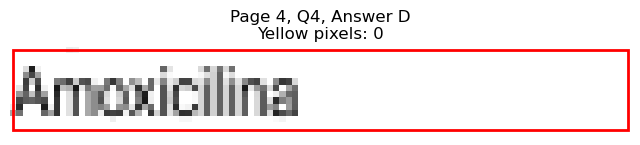


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=163.6, y1=379.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 509
Page 4, Q5, A: Yellow percentage: 0.0%


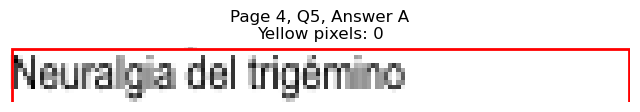

Page 4, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=103.5, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 216
Page 4, Q5, B: Yellow percentage: 0.0%


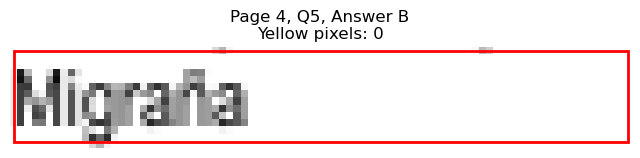

Page 4, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=399.8, y1=379.8
Page 4, Q5, C: Yellow pixels: 1310
Page 4, Q5, C: Total non-white pixels: 1599
Page 4, Q5, C: Yellow percentage: 81.9%


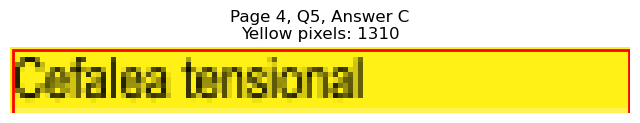

Page 4, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=407.8, y1=392.4
Page 4, Q5, D: Yellow pixels: 131
Page 4, Q5, D: Total non-white pixels: 519
Page 4, Q5, D: Yellow percentage: 25.2%


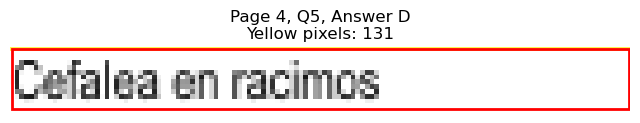


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=430.2, x1=113.9, y1=442.9
Page 4, Q6, A: Yellow pixels: 1075
Page 4, Q6, A: Total non-white pixels: 1248
Page 4, Q6, A: Yellow percentage: 86.1%


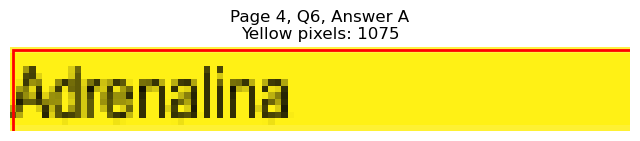

Page 4, Q6 - B: Detected box: x0=68.3, y0=442.8, x1=123.5, y1=455.5
Page 4, Q6, B: Yellow pixels: 106
Page 4, Q6, B: Total non-white pixels: 385
Page 4, Q6, B: Yellow percentage: 27.5%


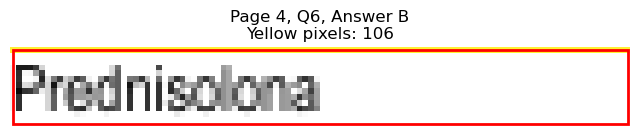

Page 4, Q6 - C: Detected box: x0=327.5, y0=430.2, x1=367.6, y1=442.9
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 193
Page 4, Q6, C: Yellow percentage: 0.0%


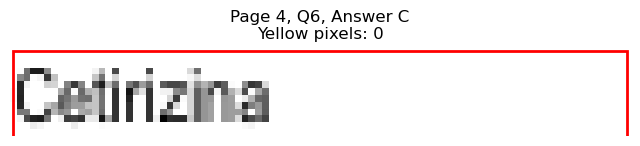

Page 4, Q6 - D: Detected box: x0=327.5, y0=442.8, x1=383.7, y1=455.5
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 294
Page 4, Q6, D: Yellow percentage: 0.0%


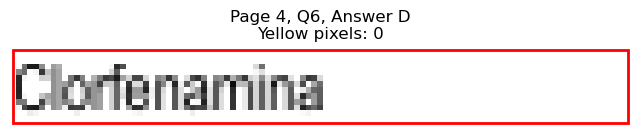


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=167.1, y1=518.6
Page 4, Q7, A: Yellow pixels: 1558
Page 4, Q7, A: Total non-white pixels: 2100
Page 4, Q7, A: Yellow percentage: 74.2%


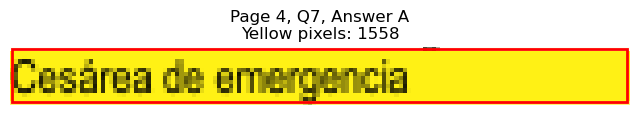

Page 4, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=131.5, y1=531.2
Page 4, Q7, B: Yellow pixels: 113
Page 4, Q7, B: Total non-white pixels: 418
Page 4, Q7, B: Yellow percentage: 27.0%


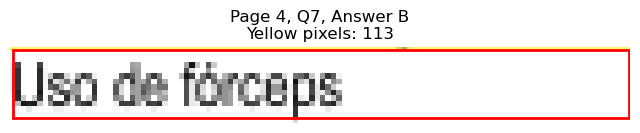

Page 4, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=410.8, y1=518.6
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 438
Page 4, Q7, C: Yellow percentage: 0.0%


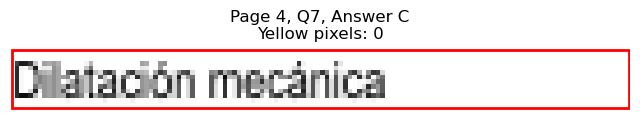

Page 4, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=419.3, y1=531.2
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 460
Page 4, Q7, D: Yellow percentage: 0.0%


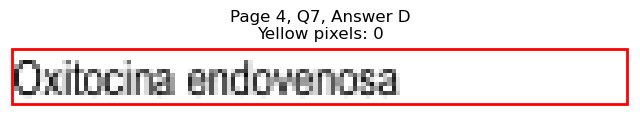


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=581.7, x1=115.0, y1=594.4
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 240
Page 4, Q8, A: Yellow percentage: 0.0%


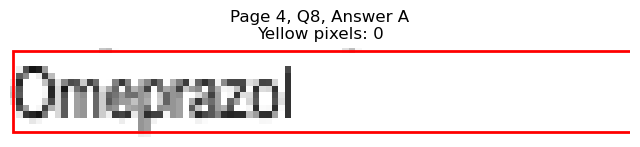

Page 4, Q8 - B: Detected box: x0=68.3, y0=594.3, x1=111.4, y1=607.0
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 231
Page 4, Q8, B: Yellow percentage: 0.0%


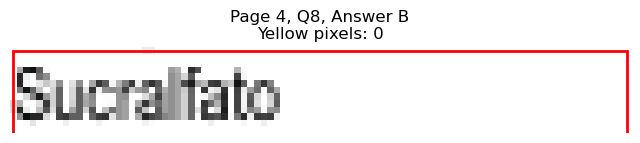

Page 4, Q8 - C: Detected box: x0=327.5, y0=581.7, x1=370.1, y1=594.4
Page 4, Q8, C: Yellow pixels: 969
Page 4, Q8, C: Total non-white pixels: 1316
Page 4, Q8, C: Yellow percentage: 73.6%


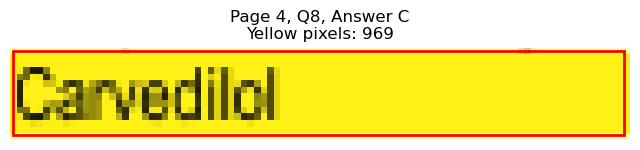

Page 4, Q8 - D: Detected box: x0=327.5, y0=594.3, x1=370.1, y1=607.0
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 334
Page 4, Q8, D: Yellow percentage: 0.0%


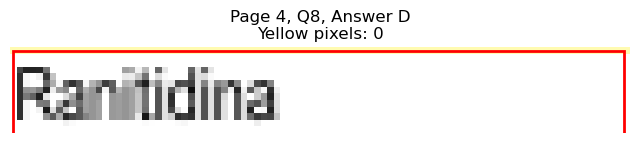


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=657.5, x1=208.2, y1=670.1
Page 4, Q9, A: Yellow pixels: 1933
Page 4, Q9, A: Total non-white pixels: 2674
Page 4, Q9, A: Yellow percentage: 72.3%


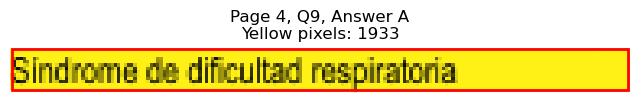

Page 4, Q9 - B: Detected box: x0=68.3, y0=670.1, x1=149.5, y1=682.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 528
Page 4, Q9, B: Yellow percentage: 0.0%


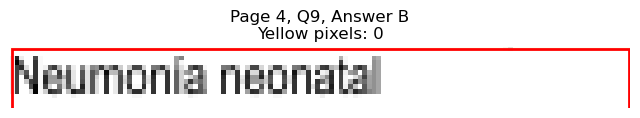

Page 4, Q9 - C: Detected box: x0=327.5, y0=657.5, x1=485.5, y1=670.1
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 842
Page 4, Q9, C: Yellow percentage: 0.0%


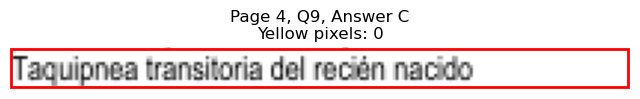

Page 4, Q9 - D: Detected box: x0=327.5, y0=670.1, x1=434.3, y1=682.7
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 561
Page 4, Q9, D: Yellow percentage: 0.0%


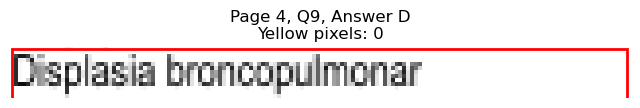


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=720.6, x1=118.0, y1=733.2
Page 4, Q10, A: Yellow pixels: 1105
Page 4, Q10, A: Total non-white pixels: 1400
Page 4, Q10, A: Yellow percentage: 78.9%


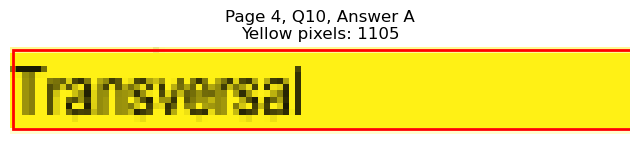

Page 4, Q10 - B: Detected box: x0=68.3, y0=733.2, x1=102.9, y1=745.8
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 257
Page 4, Q10, B: Yellow percentage: 0.0%


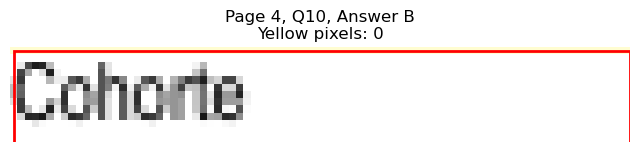

Page 4, Q10 - C: Detected box: x0=327.5, y0=720.6, x1=401.8, y1=733.2
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 353
Page 4, Q10, C: Yellow percentage: 0.0%


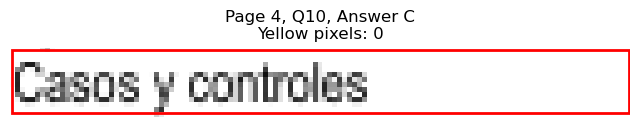

Page 4, Q10 - D: Detected box: x0=327.5, y0=733.2, x1=380.3, y1=745.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 299
Page 4, Q10, D: Yellow percentage: 0.0%


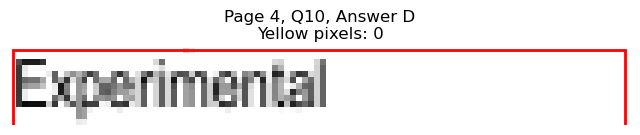


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=139.1, y1=127.3
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 360
Page 5, Q1, A: Yellow percentage: 0.0%


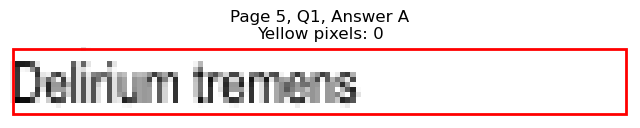

Page 5, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=188.2, y1=139.9
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 588
Page 5, Q1, B: Yellow percentage: 0.0%


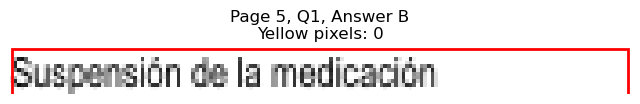

Page 5, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=457.0, y1=127.3
Page 5, Q1, C: Yellow pixels: 1653
Page 5, Q1, C: Total non-white pixels: 2534
Page 5, Q1, C: Yellow percentage: 65.2%


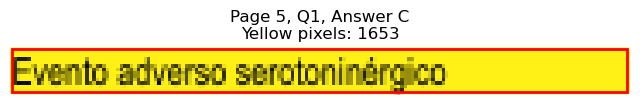

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=444.9, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 740
Page 5, Q1, D: Yellow percentage: 0.0%


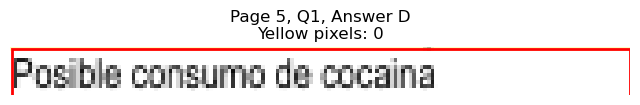


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=191.7, y1=215.6
Page 5, Q2, A: Yellow pixels: 1795
Page 5, Q2, A: Total non-white pixels: 2436
Page 5, Q2, A: Yellow percentage: 73.7%


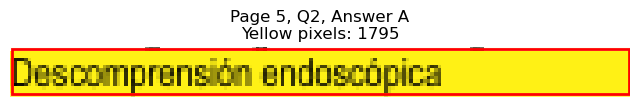

Page 5, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=175.1, y1=228.3
Page 5, Q2, B: Yellow pixels: 158
Page 5, Q2, B: Total non-white pixels: 677
Page 5, Q2, B: Yellow percentage: 23.3%


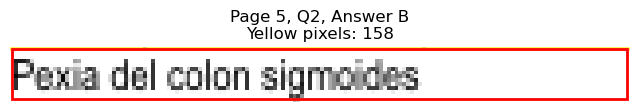

Page 5, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=442.4, y1=215.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 585
Page 5, Q2, C: Yellow percentage: 0.0%


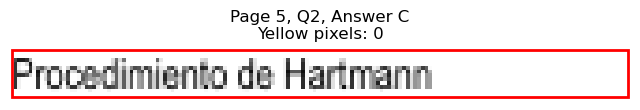

Page 5, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=432.3, y1=228.3
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 538
Page 5, Q2, D: Yellow percentage: 0.0%


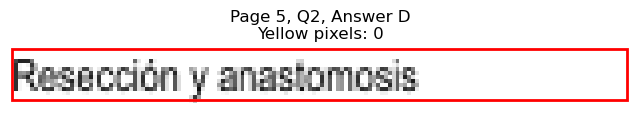


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=109.0, y1=278.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 202
Page 5, Q3, A: Yellow percentage: 0.0%


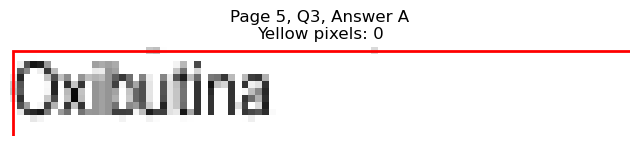

Page 5, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=173.2, y1=291.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 541
Page 5, Q3, B: Yellow percentage: 0.0%


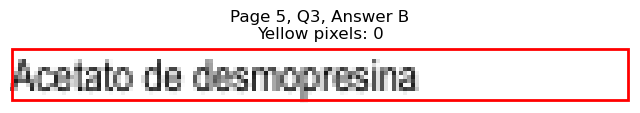

Page 5, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=371.7, y1=278.7
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 223
Page 5, Q3, C: Yellow percentage: 0.0%


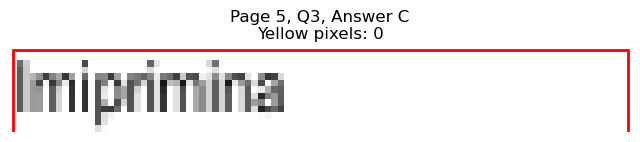

Page 5, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=380.2, y1=291.5
Page 5, Q3, D: Yellow pixels: 1144
Page 5, Q3, D: Total non-white pixels: 1456
Page 5, Q3, D: Yellow percentage: 78.6%


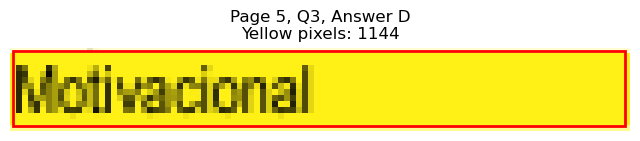


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=115.9, y1=341.9
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 248
Page 5, Q4, A: Yellow percentage: 0.0%


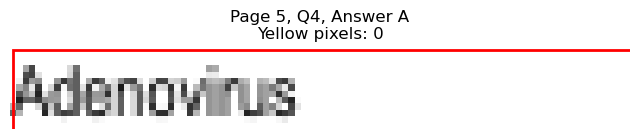

Page 5, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=171.1, y1=354.6
Page 5, Q4, B: Yellow pixels: 1571
Page 5, Q4, B: Total non-white pixels: 2156
Page 5, Q4, B: Yellow percentage: 72.9%


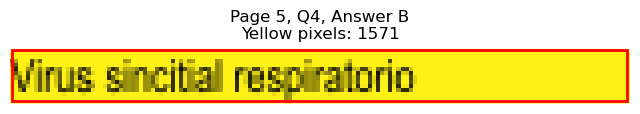

Page 5, Q4 - C: Detected box: x0=327.5, y0=329.2, x1=385.3, y1=341.9
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 286
Page 5, Q4, C: Yellow percentage: 0.0%


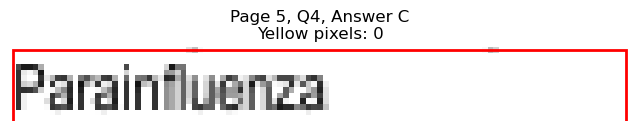

Page 5, Q4 - D: Detected box: x0=327.5, y0=341.9, x1=367.6, y1=354.6
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 205
Page 5, Q4, D: Yellow percentage: 0.0%


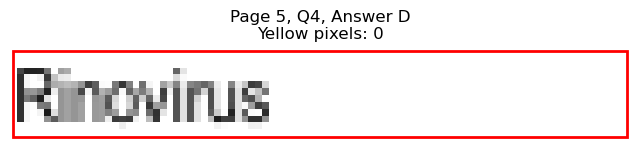


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=430.2, x1=117.5, y1=442.9
Page 5, Q5, A: Yellow pixels: 1105
Page 5, Q5, A: Total non-white pixels: 1300
Page 5, Q5, A: Yellow percentage: 85.0%


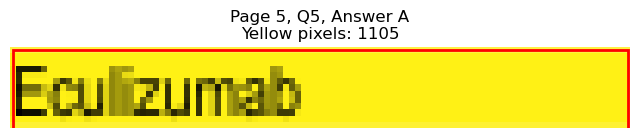

Page 5, Q5 - B: Detected box: x0=68.3, y0=442.8, x1=110.9, y1=455.5
Page 5, Q5, B: Yellow pixels: 93
Page 5, Q5, B: Total non-white pixels: 312
Page 5, Q5, B: Yellow percentage: 29.8%


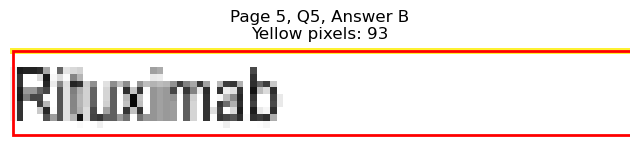

Page 5, Q5 - C: Detected box: x0=327.5, y0=430.2, x1=382.7, y1=442.9
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 268
Page 5, Q5, C: Yellow percentage: 0.0%


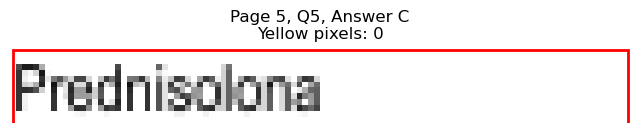

Page 5, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=389.2, y1=455.5
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 336
Page 5, Q5, D: Yellow percentage: 0.0%


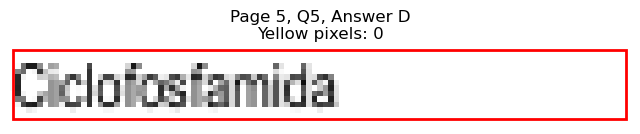


Page 5, Q5 - Selected Answer: A (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=175.6, y1=518.6
Page 5, Q6, A: Yellow pixels: 1660
Page 5, Q6, A: Total non-white pixels: 2212
Page 5, Q6, A: Yellow percentage: 75.0%


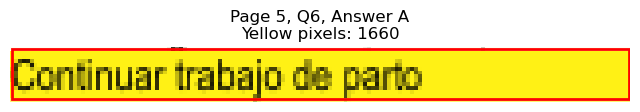

Page 5, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=139.0, y1=531.2
Page 5, Q6, B: Yellow pixels: 120
Page 5, Q6, B: Total non-white pixels: 456
Page 5, Q6, B: Yellow percentage: 26.3%


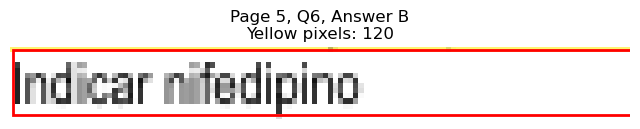

Page 5, Q6 - C: Detected box: x0=327.5, y0=506.0, x1=391.7, y1=518.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 338
Page 5, Q6, C: Yellow percentage: 0.0%


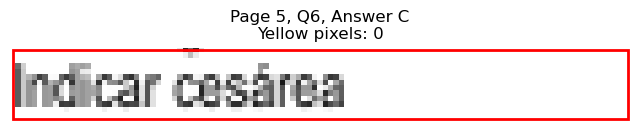

Page 5, Q6 - D: Detected box: x0=327.5, y0=518.6, x1=473.5, y1=531.2
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 766
Page 5, Q6, D: Yellow percentage: 0.0%


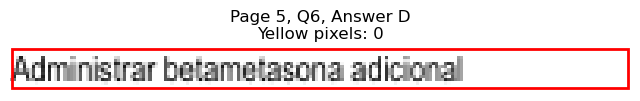


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=162.1, y1=594.4
Page 5, Q7, A: Yellow pixels: 145
Page 5, Q7, A: Total non-white pixels: 603
Page 5, Q7, A: Yellow percentage: 24.0%


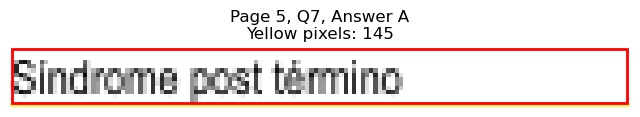

Page 5, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=101.4, y1=607.0
Page 5, Q7, B: Yellow pixels: 957
Page 5, Q7, B: Total non-white pixels: 1092
Page 5, Q7, B: Yellow percentage: 87.6%


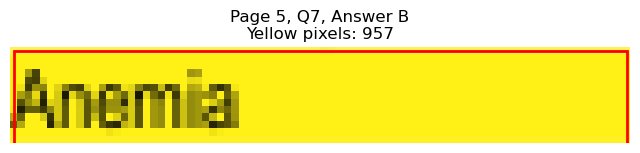

Page 5, Q7 - C: Detected box: x0=327.5, y0=581.7, x1=379.7, y1=594.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 264
Page 5, Q7, C: Yellow percentage: 0.0%


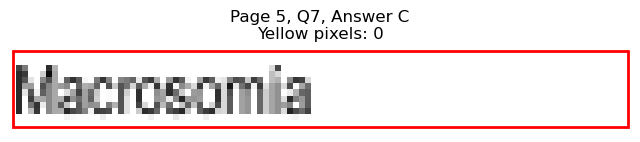

Page 5, Q7 - D: Detected box: x0=327.5, y0=594.3, x1=382.3, y1=607.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 290
Page 5, Q7, D: Yellow percentage: 0.0%


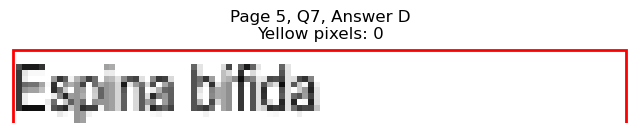


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=657.5, x1=112.0, y1=670.1
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 213
Page 5, Q8, A: Yellow percentage: 0.0%


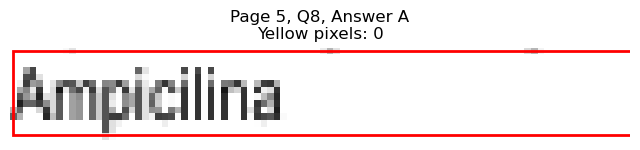

Page 5, Q8 - B: Detected box: x0=68.3, y0=670.1, x1=118.9, y1=682.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 266
Page 5, Q8, B: Yellow percentage: 0.0%


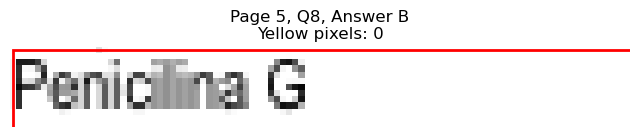

Page 5, Q8 - C: Detected box: x0=327.5, y0=657.5, x1=381.7, y1=670.1
Page 5, Q8, C: Yellow pixels: 105
Page 5, Q8, C: Total non-white pixels: 369
Page 5, Q8, C: Yellow percentage: 28.5%


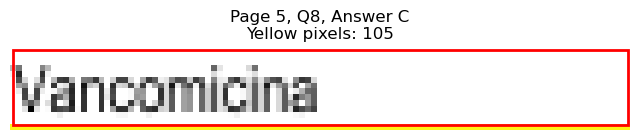

Page 5, Q8 - D: Detected box: x0=327.5, y0=670.1, x1=376.1, y1=682.7
Page 5, Q8, D: Yellow pixels: 1099
Page 5, Q8, D: Total non-white pixels: 1300
Page 5, Q8, D: Yellow percentage: 84.5%


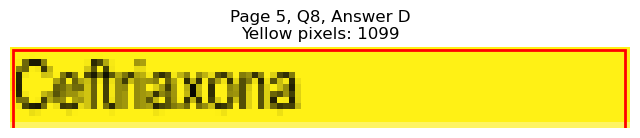


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=733.2, x1=102.5, y1=745.8
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 267
Page 5, Q9, A: Yellow percentage: 0.0%


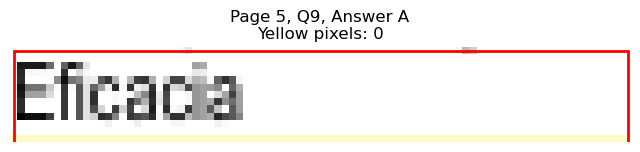

Page 5, Q9 - B: Detected box: x0=68.3, y0=745.8, x1=109.5, y1=758.4
Page 5, Q9, B: Yellow pixels: 1045
Page 5, Q9, B: Total non-white pixels: 1288
Page 5, Q9, B: Yellow percentage: 81.1%


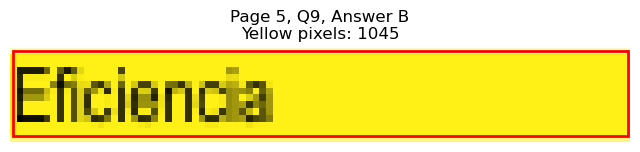

Page 5, Q9 - C: Detected box: x0=327.5, y0=733.2, x1=374.2, y1=745.8
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 240
Page 5, Q9, C: Yellow percentage: 0.0%


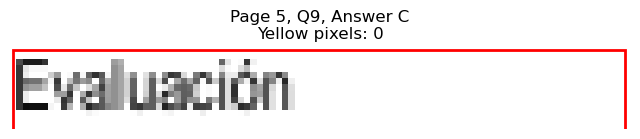

Page 5, Q9 - D: Detected box: x0=327.5, y0=745.8, x1=386.2, y1=758.4
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 288
Page 5, Q9, D: Yellow percentage: 0.0%


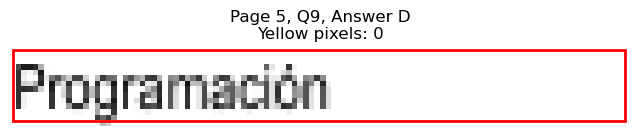


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=133.6, y1=127.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 313
Page 6, Q1, A: Yellow percentage: 0.0%


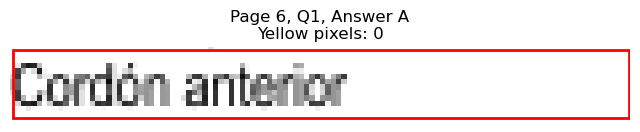

Page 6, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=119.4, y1=139.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 254
Page 6, Q1, B: Yellow percentage: 0.0%


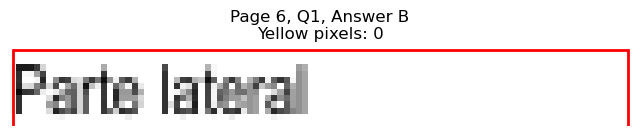

Page 6, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=351.7, y1=127.3
Page 6, Q1, C: Yellow pixels: 75
Page 6, Q1, C: Total non-white pixels: 204
Page 6, Q1, C: Yellow percentage: 36.8%


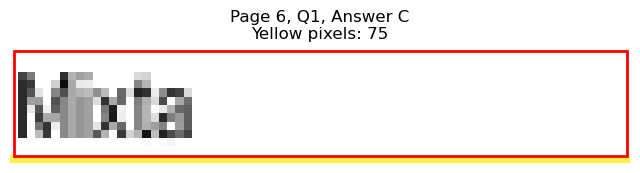

Page 6, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=397.3, y1=139.9
Page 6, Q1, D: Yellow pixels: 1306
Page 6, Q1, D: Total non-white pixels: 1573
Page 6, Q1, D: Yellow percentage: 83.0%


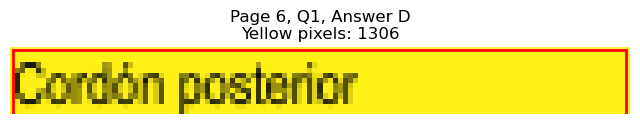


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=134.5, y1=203.0
Page 6, Q2, A: Yellow pixels: 1244
Page 6, Q2, A: Total non-white pixels: 1521
Page 6, Q2, A: Yellow percentage: 81.8%


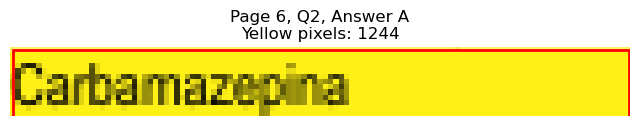

Page 6, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=109.0, y1=215.6
Page 6, Q2, B: Yellow pixels: 89
Page 6, Q2, B: Total non-white pixels: 278
Page 6, Q2, B: Yellow percentage: 32.0%


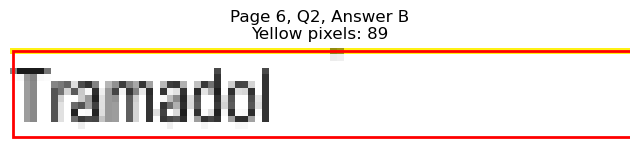

Page 6, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=404.2, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 419
Page 6, Q2, C: Yellow percentage: 0.0%


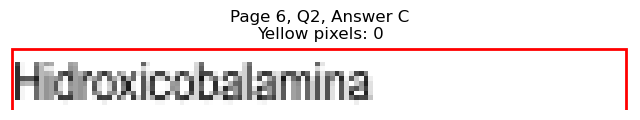

Page 6, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=386.7, y1=215.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 284
Page 6, Q2, D: Yellow percentage: 0.0%


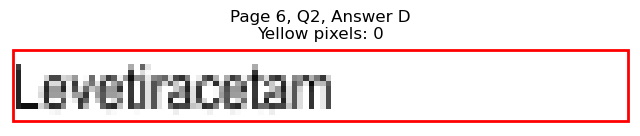


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=135.0, y1=278.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 359
Page 6, Q3, A: Yellow percentage: 0.0%


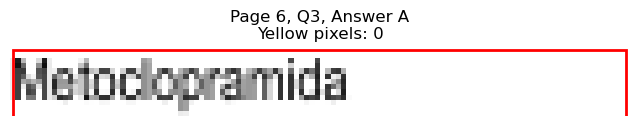

Page 6, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=119.4, y1=291.5
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 263
Page 6, Q3, B: Yellow percentage: 0.0%


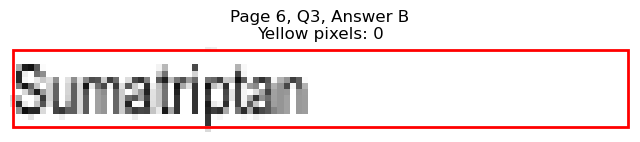

Page 6, Q3 - C: Detected box: x0=327.5, y0=266.1, x1=376.1, y1=278.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 257
Page 6, Q3, C: Yellow percentage: 0.0%


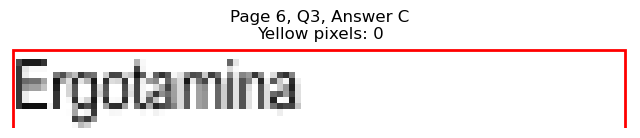

Page 6, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=373.1, y1=291.5
Page 6, Q3, D: Yellow pixels: 1106
Page 6, Q3, D: Total non-white pixels: 1358
Page 6, Q3, D: Yellow percentage: 81.4%


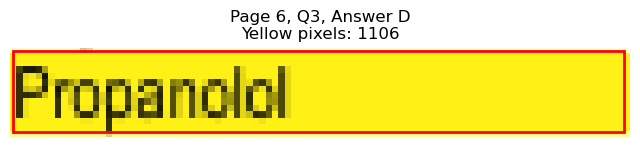


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=341.9, x1=171.1, y1=354.6
Page 6, Q4, A: Yellow pixels: 1597
Page 6, Q4, A: Total non-white pixels: 2156
Page 6, Q4, A: Yellow percentage: 74.1%


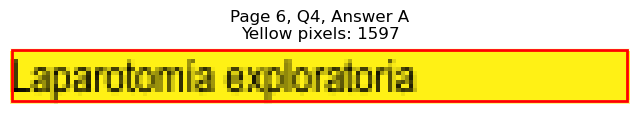

Page 6, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=93.9, y1=367.2
Page 6, Q4, B: Yellow pixels: 76
Page 6, Q4, B: Total non-white pixels: 183
Page 6, Q4, B: Yellow percentage: 41.5%


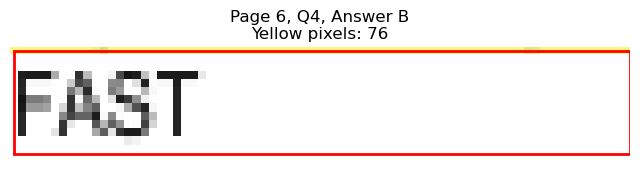

Page 6, Q4 - C: Detected box: x0=327.5, y0=341.9, x1=420.3, y1=354.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 476
Page 6, Q4, C: Yellow percentage: 0.0%


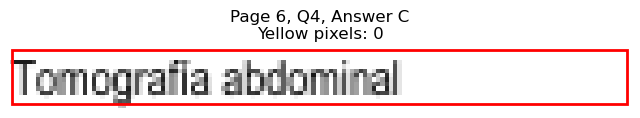

Page 6, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=433.9, y1=367.2
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 523
Page 6, Q4, D: Yellow percentage: 0.0%


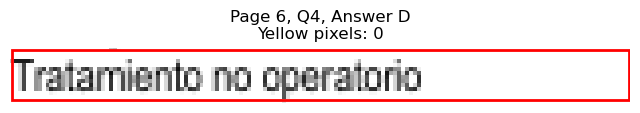


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=392.3, x1=111.4, y1=405.0
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 332
Page 6, Q5, A: Yellow percentage: 0.0%


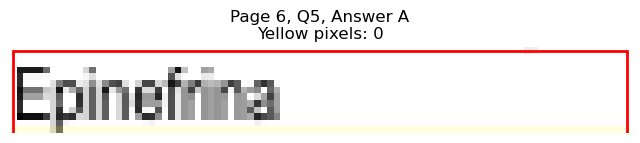

Page 6, Q5 - B: Detected box: x0=68.3, y0=404.9, x1=101.5, y1=417.6
Page 6, Q5, B: Yellow pixels: 957
Page 6, Q5, B: Total non-white pixels: 1176
Page 6, Q5, B: Yellow percentage: 81.4%


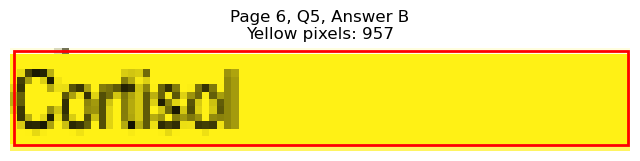

Page 6, Q5 - C: Detected box: x0=327.5, y0=392.3, x1=368.7, y1=405.0
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 195
Page 6, Q5, C: Yellow percentage: 0.0%


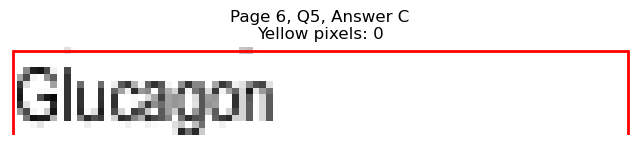

Page 6, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=361.1, y1=417.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 186
Page 6, Q5, D: Yellow percentage: 0.0%


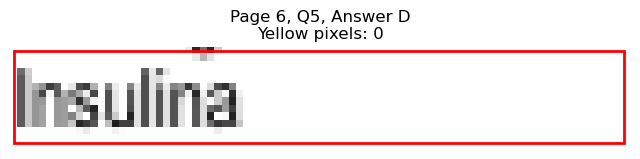


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=468.1, x1=100.9, y1=480.7
Page 6, Q6, A: Yellow pixels: 952
Page 6, Q6, A: Total non-white pixels: 1079
Page 6, Q6, A: Yellow percentage: 88.2%


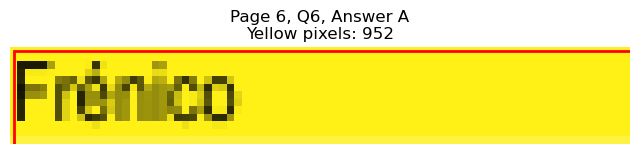

Page 6, Q6 - B: Detected box: x0=68.3, y0=480.8, x1=132.5, y1=493.4
Page 6, Q6, B: Yellow pixels: 115
Page 6, Q6, B: Total non-white pixels: 456
Page 6, Q6, B: Yellow percentage: 25.2%


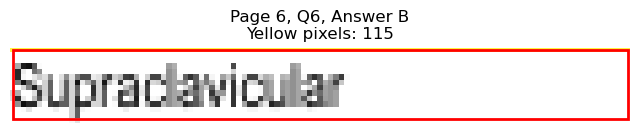

Page 6, Q6 - C: Detected box: x0=327.5, y0=468.1, x1=370.1, y1=480.7
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 239
Page 6, Q6, C: Yellow percentage: 0.0%


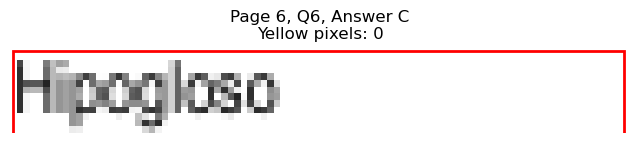

Page 6, Q6 - D: Detected box: x0=327.5, y0=480.8, x1=351.2, y1=493.4
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 121
Page 6, Q6, D: Yellow percentage: 0.0%


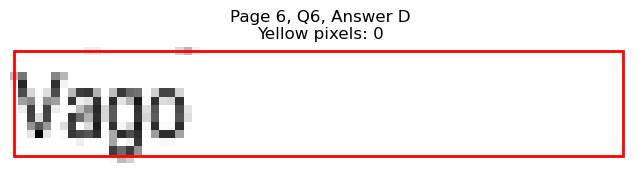


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=543.8, x1=207.4, y1=556.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 772
Page 6, Q7, A: Yellow percentage: 0.0%


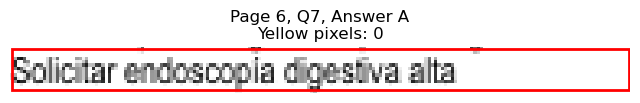

Page 6, Q7 - B: Detected box: x0=68.3, y0=556.5, x1=198.3, y1=569.2
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 642
Page 6, Q7, B: Yellow percentage: 0.0%


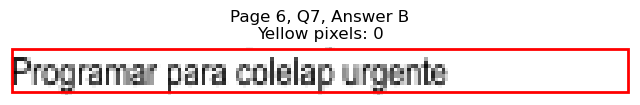

Page 6, Q7 - C: Detected box: x0=327.5, y0=543.8, x1=419.3, y1=556.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 481
Page 6, Q7, C: Yellow percentage: 0.0%


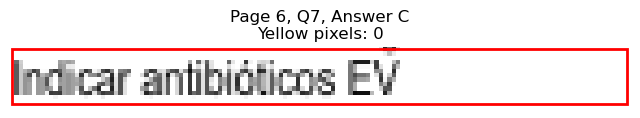

Page 6, Q7 - D: Detected box: x0=327.5, y0=556.5, x1=445.4, y1=569.2
Page 6, Q7, D: Yellow pixels: 1757
Page 6, Q7, D: Total non-white pixels: 2366
Page 6, Q7, D: Yellow percentage: 74.3%


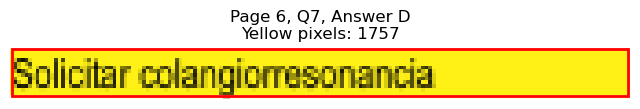


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=619.6, x1=118.5, y1=632.3
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 281
Page 6, Q8, A: Yellow percentage: 0.0%


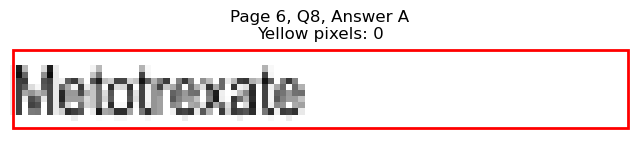

Page 6, Q8 - B: Detected box: x0=68.3, y0=632.2, x1=115.9, y1=644.9
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 220
Page 6, Q8, B: Yellow percentage: 0.0%


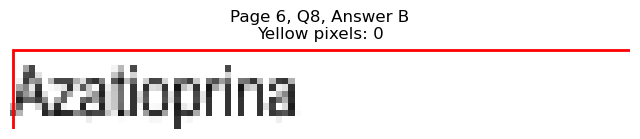

Page 6, Q8 - C: Detected box: x0=327.5, y0=619.6, x1=445.4, y1=632.3
Page 6, Q8, C: Yellow pixels: 1586
Page 6, Q8, C: Total non-white pixels: 2366
Page 6, Q8, C: Yellow percentage: 67.0%


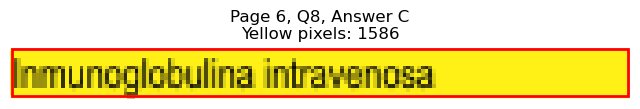

Page 6, Q8 - D: Detected box: x0=327.5, y0=632.2, x1=400.7, y1=644.9
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 525
Page 6, Q8, D: Yellow percentage: 0.0%


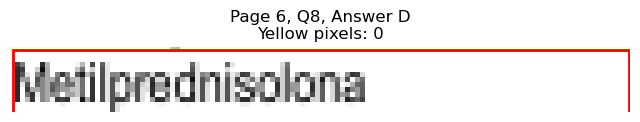


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=135.5, y1=720.6
Page 6, Q9, A: Yellow pixels: 118
Page 6, Q9, A: Total non-white pixels: 488
Page 6, Q9, A: Yellow percentage: 24.2%


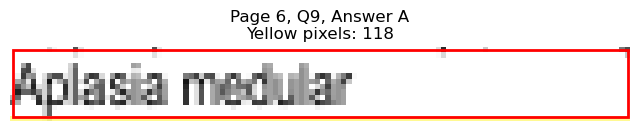

Page 6, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=109.9, y1=733.2
Page 6, Q9, B: Yellow pixels: 1044
Page 6, Q9, B: Total non-white pixels: 1288
Page 6, Q9, B: Yellow percentage: 81.1%


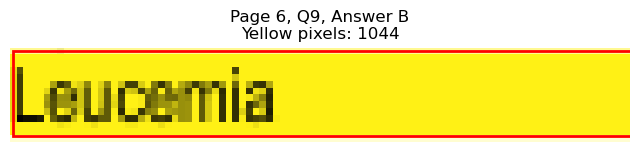

Page 6, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=446.9, y1=720.6
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 590
Page 6, Q9, C: Yellow percentage: 0.0%


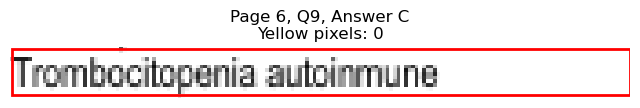

Page 6, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=364.6, y1=733.2
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 147
Page 6, Q9, D: Yellow percentage: 0.0%


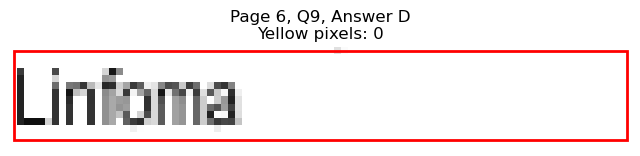


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=103.9, y1=114.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 196
Page 7, Q1, A: Yellow percentage: 0.0%


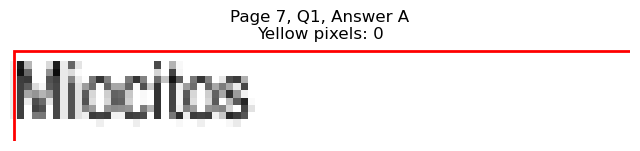

Page 7, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=175.1, y1=127.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 543
Page 7, Q1, B: Yellow percentage: 0.0%


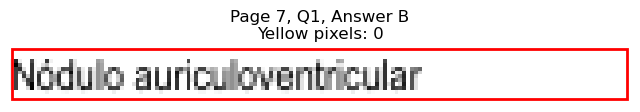

Page 7, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=402.8, y1=114.7
Page 7, Q1, C: Yellow pixels: 1329
Page 7, Q1, C: Total non-white pixels: 1638
Page 7, Q1, C: Yellow percentage: 81.1%


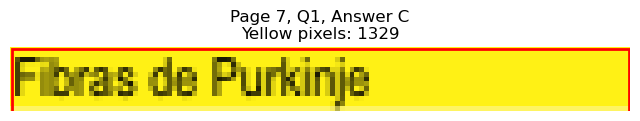

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=412.3, y1=127.3
Page 7, Q1, D: Yellow pixels: 135
Page 7, Q1, D: Total non-white pixels: 579
Page 7, Q1, D: Yellow percentage: 23.3%


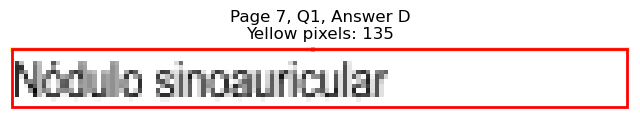


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=95.9, y1=177.8
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 206
Page 7, Q2, A: Yellow percentage: 0.0%


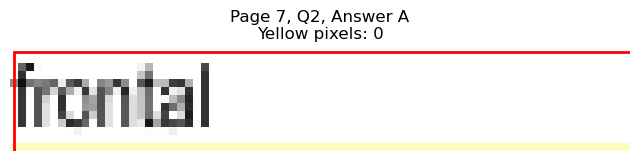

Page 7, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=138.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 1182
Page 7, Q2, B: Total non-white pixels: 1694
Page 7, Q2, B: Yellow percentage: 69.8%


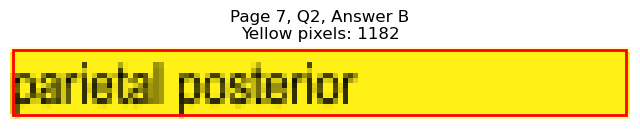

Page 7, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=362.7, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 197
Page 7, Q2, C: Yellow percentage: 0.0%


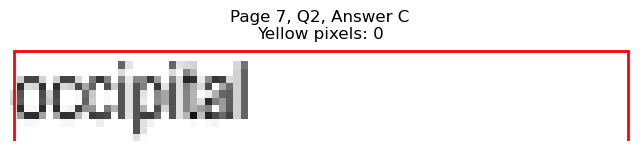

Page 7, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=392.7, y1=190.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 336
Page 7, Q2, D: Yellow percentage: 0.0%


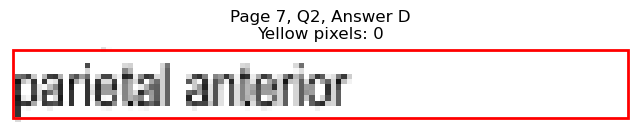


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=160.7, y1=253.5
Page 7, Q3, A: Yellow pixels: 143
Page 7, Q3, A: Total non-white pixels: 586
Page 7, Q3, A: Yellow percentage: 24.4%


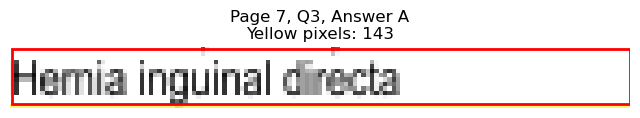

Page 7, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=142.6, y1=266.1
Page 7, Q3, B: Yellow pixels: 1320
Page 7, Q3, B: Total non-white pixels: 1750
Page 7, Q3, B: Yellow percentage: 75.4%


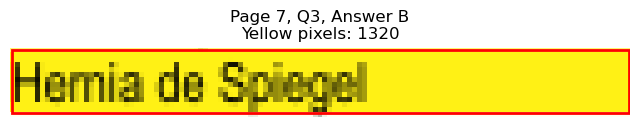

Page 7, Q3 - C: Detected box: x0=327.5, y0=240.9, x1=406.4, y1=253.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 423
Page 7, Q3, C: Yellow percentage: 0.0%


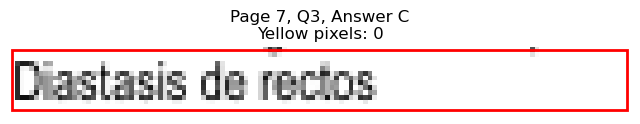

Page 7, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=422.0, y1=266.1
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 479
Page 7, Q3, D: Yellow percentage: 0.0%


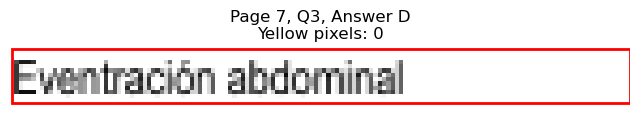


Page 7, Q3 - Selected Answer: B (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=304.0, x1=141.5, y1=316.7
Page 7, Q4, A: Yellow pixels: 2
Page 7, Q4, A: Total non-white pixels: 500
Page 7, Q4, A: Yellow percentage: 0.4%


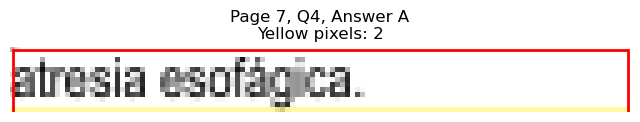

Page 7, Q4 - B: Detected box: x0=68.3, y0=316.6, x1=169.1, y1=329.3
Page 7, Q4, B: Yellow pixels: 1446
Page 7, Q4, B: Total non-white pixels: 2128
Page 7, Q4, B: Yellow percentage: 68.0%


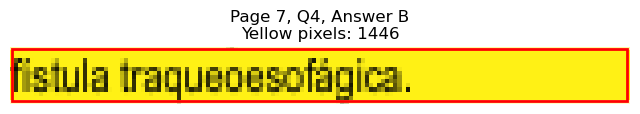

Page 7, Q4 - C: Detected box: x0=327.5, y0=304.0, x1=423.3, y1=316.7
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 502
Page 7, Q4, C: Yellow percentage: 0.0%


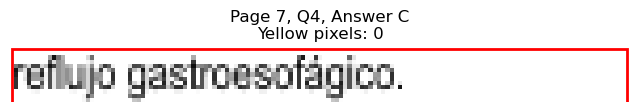

Page 7, Q4 - D: Detected box: x0=327.5, y0=316.6, x1=403.7, y1=329.3
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 387
Page 7, Q4, D: Yellow percentage: 0.0%


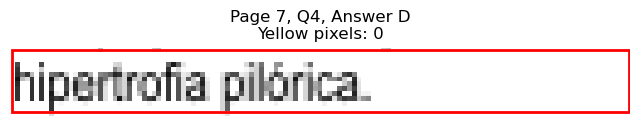


Page 7, Q4 - Selected Answer: B (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=367.1, x1=188.2, y1=379.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 620
Page 7, Q5, A: Yellow percentage: 0.0%


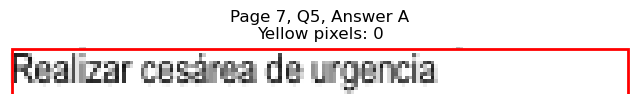

Page 7, Q5 - B: Detected box: x0=68.3, y0=379.7, x1=187.2, y1=392.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 624
Page 7, Q5, B: Yellow percentage: 0.0%


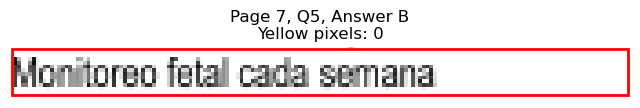

Page 7, Q5 - C: Detected box: x0=327.5, y0=367.1, x1=440.3, y1=379.8
Page 7, Q5, C: Yellow pixels: 2
Page 7, Q5, C: Total non-white pixels: 721
Page 7, Q5, C: Yellow percentage: 0.3%


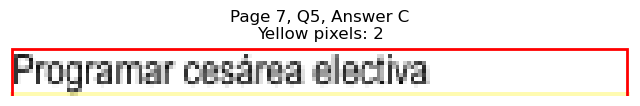

Page 7, Q5 - D: Detected box: x0=327.5, y0=379.7, x1=460.4, y1=392.4
Page 7, Q5, D: Yellow pixels: 1741
Page 7, Q5, D: Total non-white pixels: 2576
Page 7, Q5, D: Yellow percentage: 67.6%


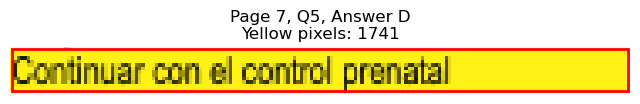


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=417.6, x1=129.5, y1=430.3
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 327
Page 7, Q6, A: Yellow percentage: 0.0%


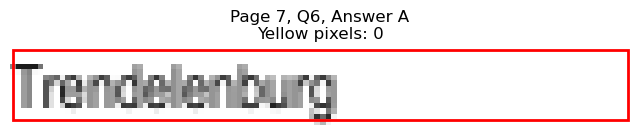

Page 7, Q6 - B: Detected box: x0=68.3, y0=430.2, x1=135.5, y1=442.9
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 338
Page 7, Q6, B: Yellow percentage: 0.0%


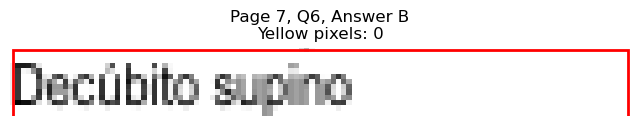

Page 7, Q6 - C: Detected box: x0=327.5, y0=417.6, x1=391.3, y1=430.3
Page 7, Q6, C: Yellow pixels: 1142
Page 7, Q6, C: Total non-white pixels: 1610
Page 7, Q6, C: Yellow percentage: 70.9%


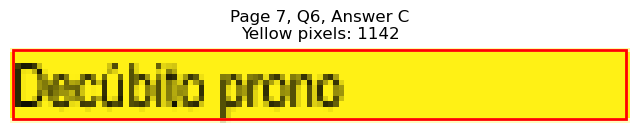

Page 7, Q6 - D: Detected box: x0=327.5, y0=430.2, x1=392.7, y1=442.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 464
Page 7, Q6, D: Yellow percentage: 0.0%


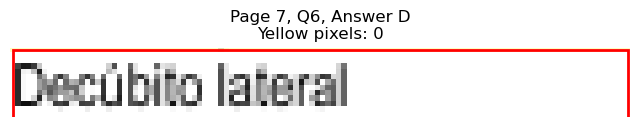


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=506.0, x1=179.2, y1=518.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 560
Page 7, Q7, A: Yellow percentage: 0.0%


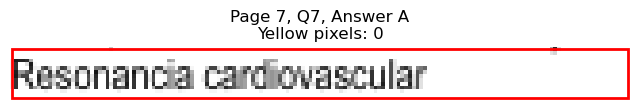

Page 7, Q7 - B: Detected box: x0=68.3, y0=518.6, x1=162.6, y1=531.2
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 458
Page 7, Q7, B: Yellow percentage: 0.0%


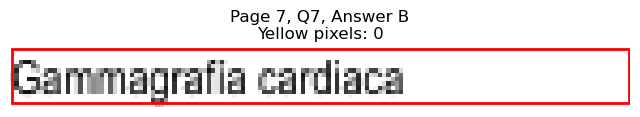

Page 7, Q7 - C: Detected box: x0=327.5, y0=506.0, x1=436.9, y1=518.6
Page 7, Q7, C: Yellow pixels: 160
Page 7, Q7, C: Total non-white pixels: 705
Page 7, Q7, C: Yellow percentage: 22.7%


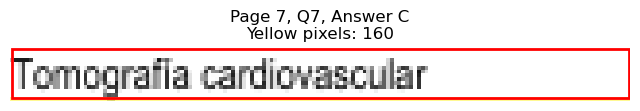

Page 7, Q7 - D: Detected box: x0=327.5, y0=518.6, x1=453.4, y1=531.2
Page 7, Q7, D: Yellow pixels: 1844
Page 7, Q7, D: Total non-white pixels: 2478
Page 7, Q7, D: Yellow percentage: 74.4%


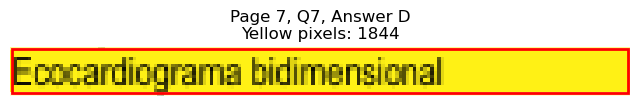


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=569.1, x1=136.5, y1=581.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 337
Page 7, Q8, A: Yellow percentage: 0.0%


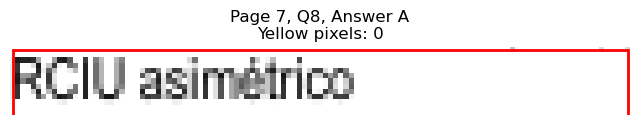

Page 7, Q8 - B: Detected box: x0=68.3, y0=581.7, x1=124.5, y1=594.4
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 258
Page 7, Q8, B: Yellow percentage: 0.0%


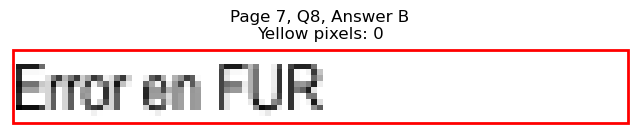

Page 7, Q8 - C: Detected box: x0=327.5, y0=569.1, x1=390.7, y1=581.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 425
Page 7, Q8, C: Yellow percentage: 0.0%


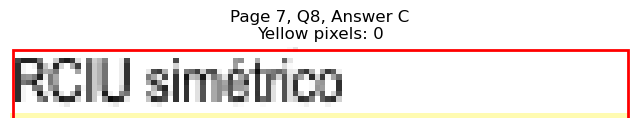

Page 7, Q8 - D: Detected box: x0=327.5, y0=581.7, x1=469.5, y1=594.4
Page 7, Q8, D: Yellow pixels: 1751
Page 7, Q8, D: Total non-white pixels: 2702
Page 7, Q8, D: Yellow percentage: 64.8%


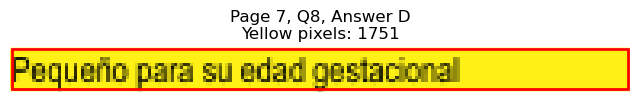


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=632.2, x1=113.9, y1=644.9
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 237
Page 7, Q9, A: Yellow percentage: 0.0%


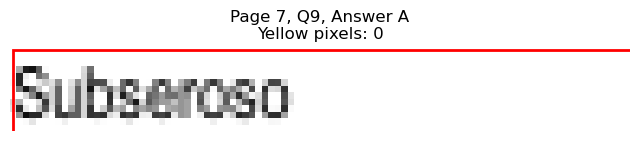

Page 7, Q9 - B: Detected box: x0=68.3, y0=644.9, x1=115.5, y1=657.5
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 262
Page 7, Q9, B: Yellow percentage: 0.0%


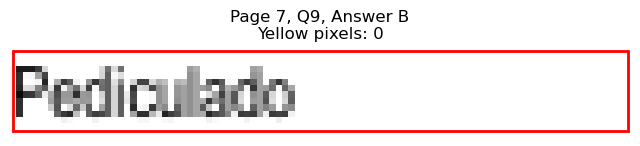

Page 7, Q9 - C: Detected box: x0=327.5, y0=632.2, x1=370.6, y1=644.9
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 307
Page 7, Q9, C: Yellow percentage: 0.0%


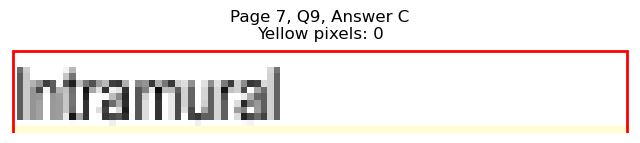

Page 7, Q9 - D: Detected box: x0=327.5, y0=644.9, x1=377.7, y1=657.5
Page 7, Q9, D: Yellow pixels: 1130
Page 7, Q9, D: Total non-white pixels: 1414
Page 7, Q9, D: Yellow percentage: 79.9%


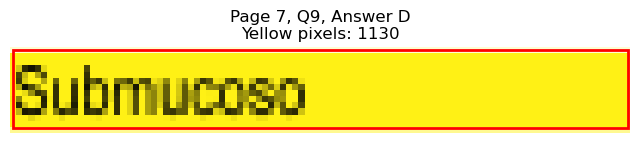


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=695.4, x1=176.7, y1=708.0
Page 7, Q10, A: Yellow pixels: 1641
Page 7, Q10, A: Total non-white pixels: 2068
Page 7, Q10, A: Yellow percentage: 79.4%


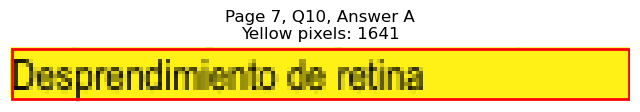

Page 7, Q10 - B: Detected box: x0=68.3, y0=708.0, x1=133.5, y1=720.6
Page 7, Q10, B: Yellow pixels: 115
Page 7, Q10, B: Total non-white pixels: 455
Page 7, Q10, B: Yellow percentage: 25.3%


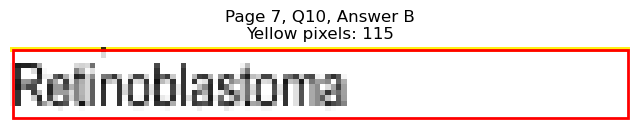

Page 7, Q10 - C: Detected box: x0=327.5, y0=695.4, x1=417.8, y1=708.0
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 445
Page 7, Q10, C: Yellow percentage: 0.0%


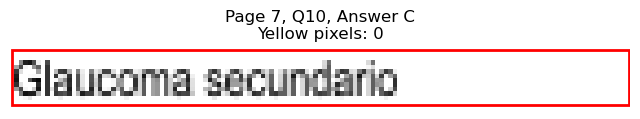

Page 7, Q10 - D: Detected box: x0=327.5, y0=708.0, x1=409.3, y1=720.6
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 429
Page 7, Q10, D: Yellow percentage: 0.0%


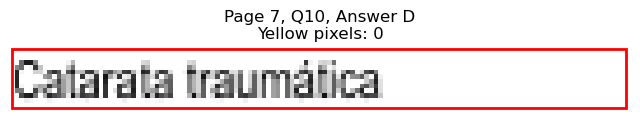


Page 7, Q10 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=140.1, y1=139.9
Page 8, Q1, A: Yellow pixels: 1307
Page 8, Q1, A: Total non-white pixels: 1599
Page 8, Q1, A: Yellow percentage: 81.7%


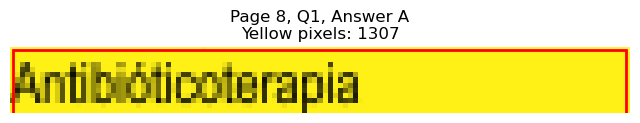

Page 8, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=126.0, y1=152.6
Page 8, Q1, B: Yellow pixels: 108
Page 8, Q1, B: Total non-white pixels: 423
Page 8, Q1, B: Yellow percentage: 25.5%


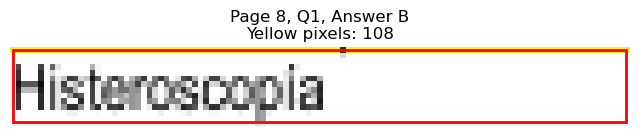

Page 8, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=430.4, y1=139.9
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 513
Page 8, Q1, C: Yellow percentage: 0.0%


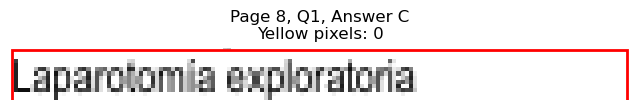

Page 8, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=394.3, y1=152.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 363
Page 8, Q1, D: Yellow percentage: 0.0%


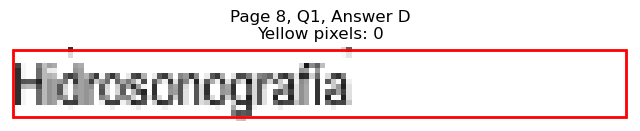


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=108.4, y1=228.3
Page 8, Q2, A: Yellow pixels: 915
Page 8, Q2, A: Total non-white pixels: 1274
Page 8, Q2, A: Yellow percentage: 71.8%


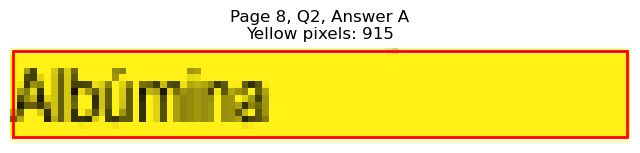

Page 8, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=129.5, y1=240.9
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 426
Page 8, Q2, B: Yellow percentage: 0.0%


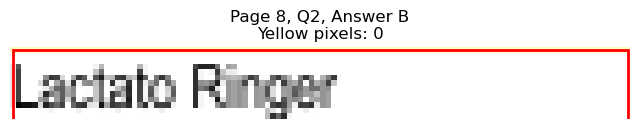

Page 8, Q2 - C: Detected box: x0=327.5, y0=215.7, x1=369.2, y1=228.3
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 206
Page 8, Q2, C: Yellow percentage: 0.0%


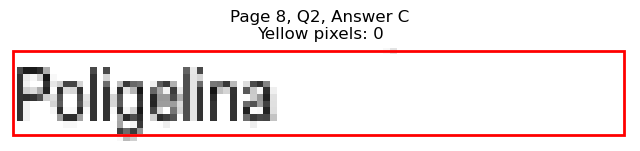

Page 8, Q2 - D: Detected box: x0=327.5, y0=228.3, x1=381.7, y1=240.9
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 276
Page 8, Q2, D: Yellow percentage: 0.0%


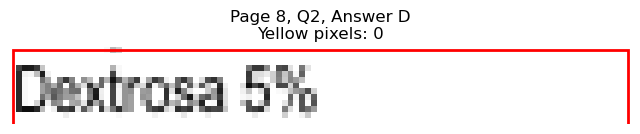


Page 8, Q2 - Selected Answer: A (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=291.4, x1=179.7, y1=304.1
Page 8, Q3, A: Yellow pixels: 1684
Page 8, Q3, A: Total non-white pixels: 2268
Page 8, Q3, A: Yellow percentage: 74.3%


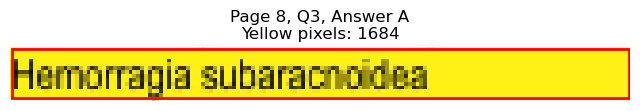

Page 8, Q3 - B: Detected box: x0=68.3, y0=304.0, x1=173.2, y1=316.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 736
Page 8, Q3, B: Yellow percentage: 0.0%


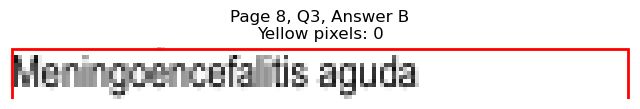

Page 8, Q3 - C: Detected box: x0=327.5, y0=291.4, x1=446.8, y1=304.1
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 627
Page 8, Q3, C: Yellow percentage: 0.0%


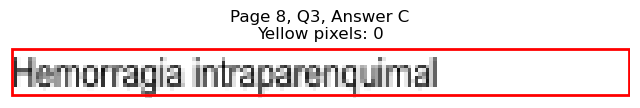

Page 8, Q3 - D: Detected box: x0=327.5, y0=304.0, x1=382.7, y1=316.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 275
Page 8, Q3, D: Yellow percentage: 0.0%


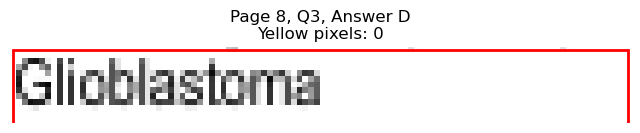


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=155.5, y1=379.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 462
Page 8, Q4, A: Yellow percentage: 0.0%


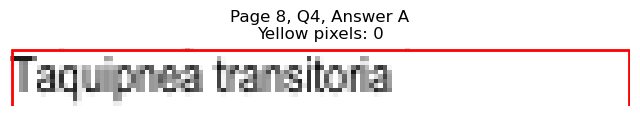

Page 8, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=135.0, y1=392.4
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 351
Page 8, Q4, B: Yellow percentage: 0.0%


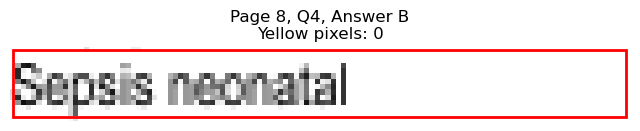

Page 8, Q4 - C: Detected box: x0=327.5, y0=367.1, x1=420.8, y1=379.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 613
Page 8, Q4, C: Yellow percentage: 0.0%


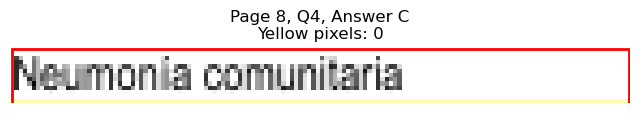

Page 8, Q4 - D: Detected box: x0=327.5, y0=379.7, x1=416.3, y1=392.4
Page 8, Q4, D: Yellow pixels: 1317
Page 8, Q4, D: Total non-white pixels: 1960
Page 8, Q4, D: Yellow percentage: 67.2%


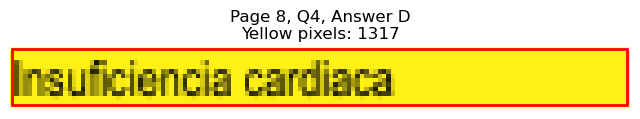


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=106.5, y1=430.3
Page 8, Q5, A: Yellow pixels: 89
Page 8, Q5, A: Total non-white pixels: 287
Page 8, Q5, A: Yellow percentage: 31.0%


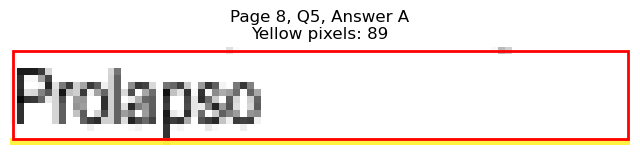

Page 8, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=105.9, y1=442.9
Page 8, Q5, B: Yellow pixels: 1003
Page 8, Q5, B: Total non-white pixels: 1144
Page 8, Q5, B: Yellow percentage: 87.7%


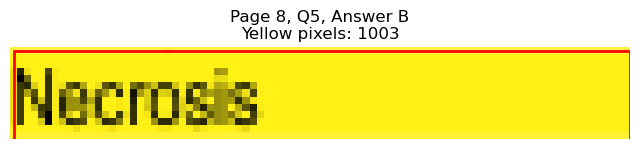

Page 8, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=408.8, y1=430.3
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 416
Page 8, Q5, C: Yellow percentage: 0.0%


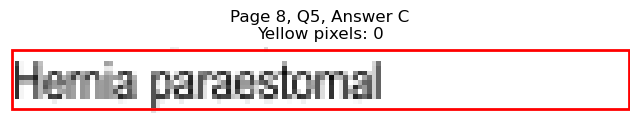

Page 8, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=373.1, y1=442.9
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 235
Page 8, Q5, D: Yellow percentage: 0.0%


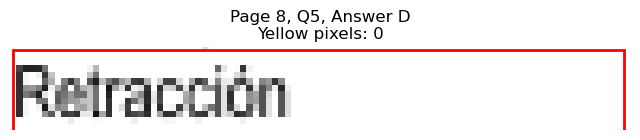


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=518.6, x1=93.9, y1=531.2
Page 8, Q6, A: Yellow pixels: 76
Page 8, Q6, A: Total non-white pixels: 185
Page 8, Q6, A: Yellow percentage: 41.1%


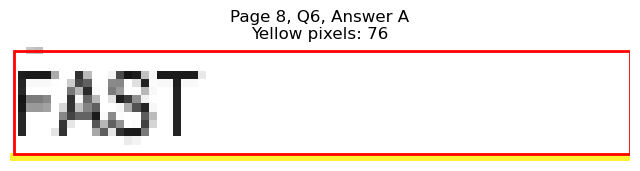

Page 8, Q6 - B: Detected box: x0=68.3, y0=531.2, x1=210.8, y1=543.8
Page 8, Q6, B: Yellow pixels: 1948
Page 8, Q6, B: Total non-white pixels: 2509
Page 8, Q6, B: Yellow percentage: 77.6%


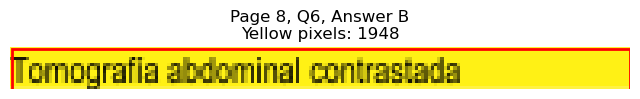

Page 8, Q6 - C: Detected box: x0=327.5, y0=518.6, x1=429.4, y1=531.2
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 537
Page 8, Q6, C: Yellow percentage: 0.0%


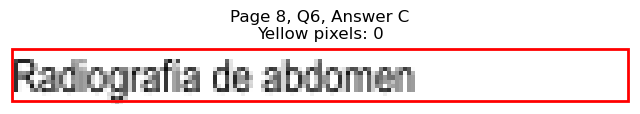

Page 8, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=412.9, y1=543.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 444
Page 8, Q6, D: Yellow percentage: 0.0%


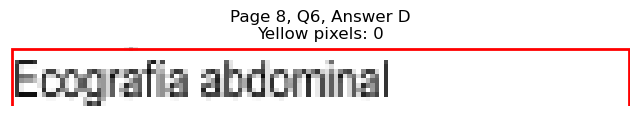


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=80.9, y1=594.4
Page 8, Q7, A: Yellow pixels: 63
Page 8, Q7, A: Total non-white pixels: 114
Page 8, Q7, A: Yellow percentage: 55.3%


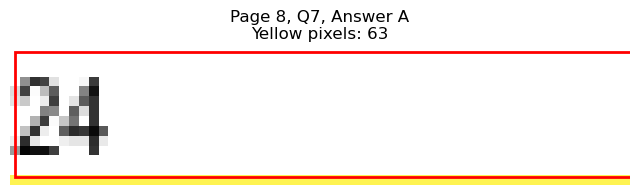

Page 8, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=80.9, y1=607.0
Page 8, Q7, B: Yellow pixels: 774
Page 8, Q7, B: Total non-white pixels: 819
Page 8, Q7, B: Yellow percentage: 94.5%


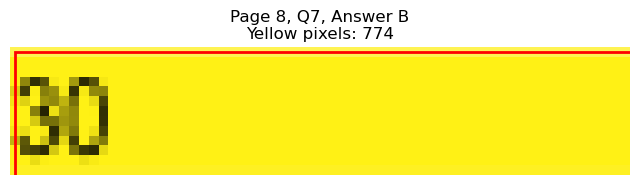

Page 8, Q7 - C: Detected box: x0=327.5, y0=581.7, x1=340.1, y1=594.4
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 46
Page 8, Q7, C: Yellow percentage: 0.0%


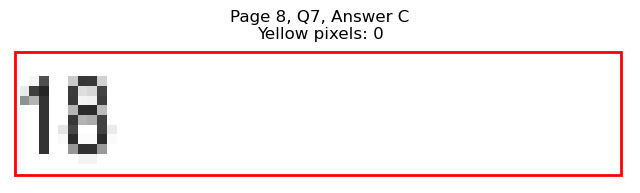

Page 8, Q7 - D: Detected box: x0=327.5, y0=594.3, x1=340.1, y1=607.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 39
Page 8, Q7, D: Yellow percentage: 0.0%


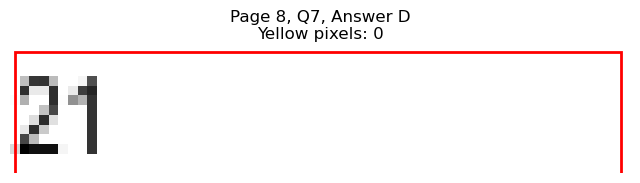


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=644.9, x1=136.0, y1=657.5
Page 8, Q8, A: Yellow pixels: 118
Page 8, Q8, A: Total non-white pixels: 454
Page 8, Q8, A: Yellow percentage: 26.0%


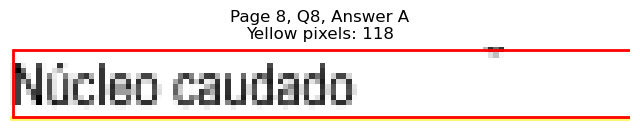

Page 8, Q8 - B: Detected box: x0=68.3, y0=657.5, x1=140.1, y1=670.1
Page 8, Q8, B: Yellow pixels: 1318
Page 8, Q8, B: Total non-white pixels: 1722
Page 8, Q8, B: Yellow percentage: 76.5%


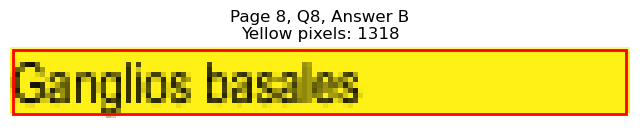

Page 8, Q8 - C: Detected box: x0=327.5, y0=644.9, x1=389.3, y1=657.5
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 310
Page 8, Q8, C: Yellow percentage: 0.0%


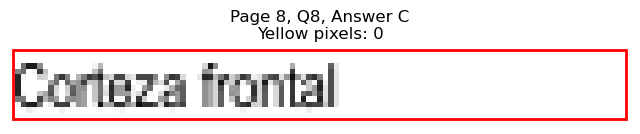

Page 8, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=393.8, y1=670.1
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 351
Page 8, Q8, D: Yellow percentage: 0.0%


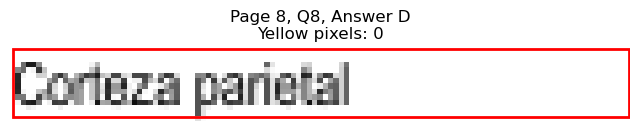


Page 8, Q8 - Selected Answer: B (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=145.6, y1=708.0
Page 8, Q9, A: Yellow pixels: 1304
Page 8, Q9, A: Total non-white pixels: 1667
Page 8, Q9, A: Yellow percentage: 78.2%


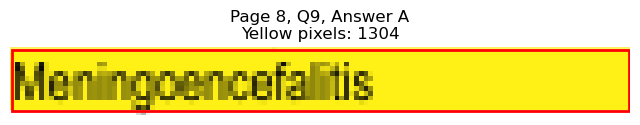

Page 8, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=119.4, y1=720.6
Page 8, Q9, B: Yellow pixels: 98
Page 8, Q9, B: Total non-white pixels: 375
Page 8, Q9, B: Yellow percentage: 26.1%


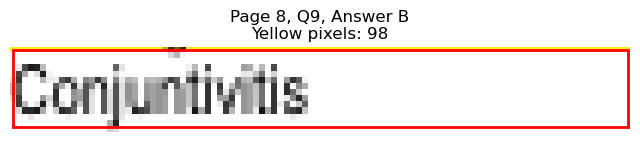

Page 8, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=397.3, y1=708.0
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 352
Page 8, Q9, C: Yellow percentage: 0.0%


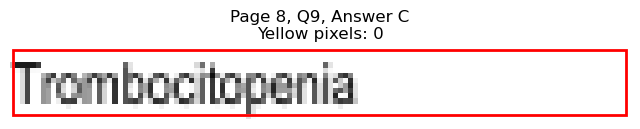

Page 8, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=374.7, y1=720.6
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 259
Page 8, Q9, D: Yellow percentage: 0.0%


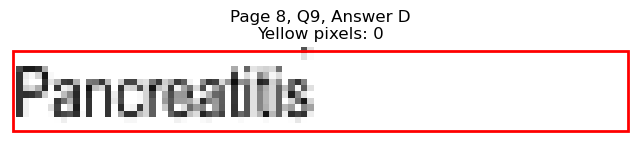


Page 8, Q9 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=153.6, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 445
Page 9, Q1, A: Yellow percentage: 0.0%


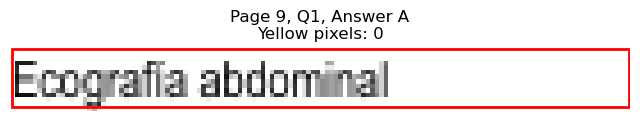

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=180.6, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 513
Page 9, Q1, B: Yellow percentage: 0.0%


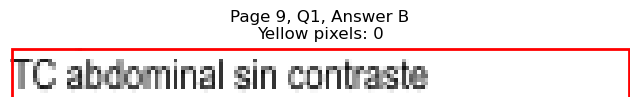

Page 9, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=422.3, y1=127.3
Page 9, Q1, C: Yellow pixels: 146
Page 9, Q1, C: Total non-white pixels: 619
Page 9, Q1, C: Yellow percentage: 23.6%


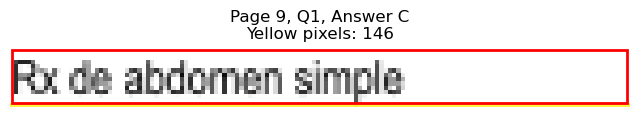

Page 9, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=422.3, y1=139.9
Page 9, Q1, D: Yellow pixels: 1514
Page 9, Q1, D: Total non-white pixels: 1898
Page 9, Q1, D: Yellow percentage: 79.8%


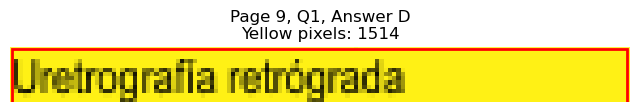


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=123.0, y1=215.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 241
Page 9, Q2, A: Yellow percentage: 0.0%


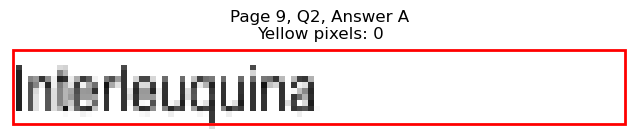

Page 9, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=131.5, y1=228.3
Page 9, Q2, B: Yellow pixels: 1114
Page 9, Q2, B: Total non-white pixels: 1596
Page 9, Q2, B: Yellow percentage: 69.8%


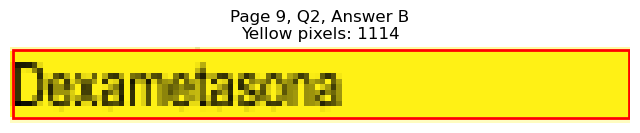

Page 9, Q2 - C: Detected box: x0=327.5, y0=202.9, x1=375.7, y1=215.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 253
Page 9, Q2, C: Yellow percentage: 0.0%


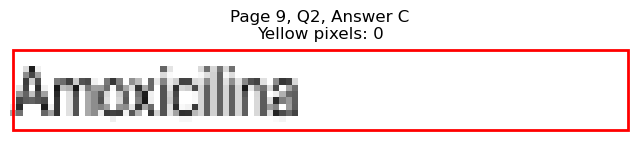

Page 9, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=376.7, y1=228.3
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 253
Page 9, Q2, D: Yellow percentage: 0.0%


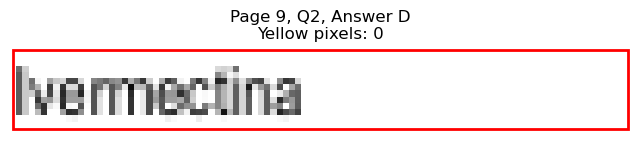


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=115.0, y1=291.5
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 204
Page 9, Q3, A: Yellow percentage: 0.0%


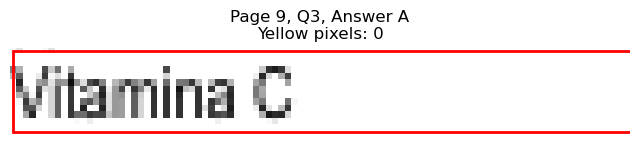

Page 9, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=127.9, y1=304.1
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 288
Page 9, Q3, B: Yellow percentage: 0.0%


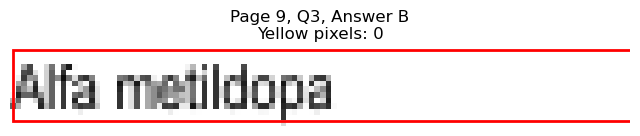

Page 9, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=412.7, y1=291.5
Page 9, Q3, C: Yellow pixels: 1454
Page 9, Q3, C: Total non-white pixels: 1904
Page 9, Q3, C: Yellow percentage: 76.4%


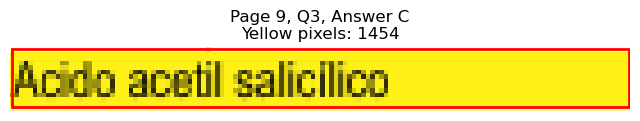

Page 9, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=370.1, y1=304.1
Page 9, Q3, D: Yellow pixels: 94
Page 9, Q3, D: Total non-white pixels: 329
Page 9, Q3, D: Yellow percentage: 28.6%


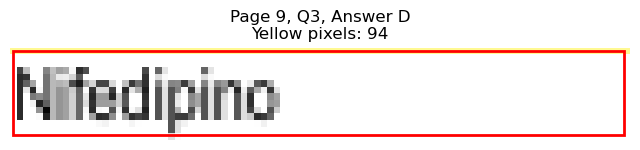


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=101.9, y1=367.2
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 157
Page 9, Q4, A: Yellow percentage: 0.0%


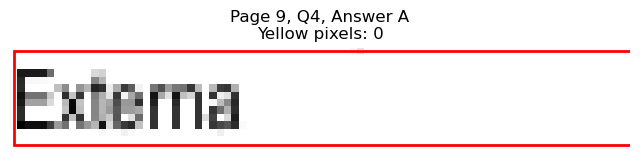

Page 9, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=127.0, y1=379.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 315
Page 9, Q4, B: Yellow percentage: 0.0%


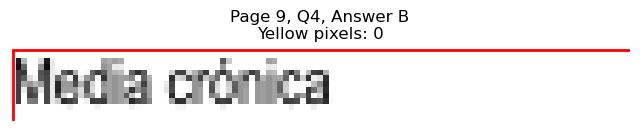

Page 9, Q4 - C: Detected box: x0=327.5, y0=354.5, x1=358.1, y1=367.2
Page 9, Q4, C: Yellow pixels: 82
Page 9, Q4, C: Total non-white pixels: 241
Page 9, Q4, C: Yellow percentage: 34.0%


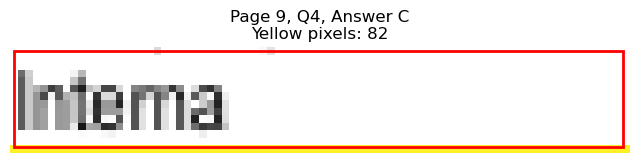

Page 9, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=382.3, y1=379.8
Page 9, Q4, D: Yellow pixels: 1156
Page 9, Q4, D: Total non-white pixels: 1378
Page 9, Q4, D: Yellow percentage: 83.9%


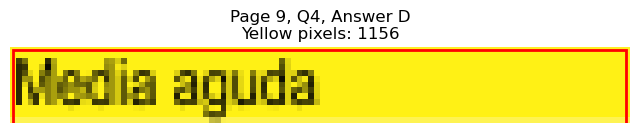


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=417.6, x1=83.4, y1=430.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 69
Page 9, Q5, A: Yellow percentage: 0.0%


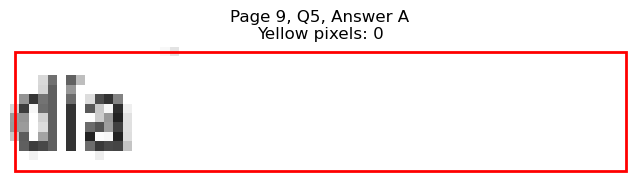

Page 9, Q5 - B: Detected box: x0=68.3, y0=430.2, x1=124.9, y1=442.9
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 273
Page 9, Q5, B: Yellow percentage: 0.0%


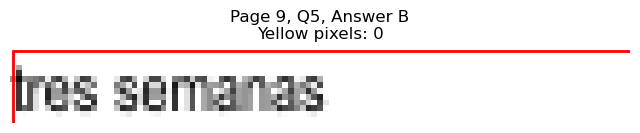

Page 9, Q5 - C: Detected box: x0=327.5, y0=417.6, x1=362.1, y1=430.3
Page 9, Q5, C: Yellow pixels: 902
Page 9, Q5, C: Total non-white pixels: 1204
Page 9, Q5, C: Yellow percentage: 74.9%


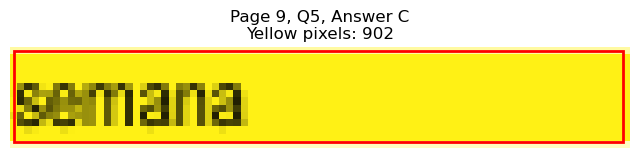

Page 9, Q5 - D: Detected box: x0=327.5, y0=430.2, x1=394.3, y1=442.9
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 443
Page 9, Q5, D: Yellow percentage: 0.0%


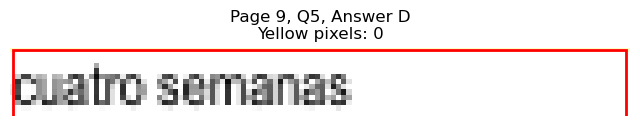


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=114.6, x1=153.6, y1=127.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 445
Page 9, Q6, A: Yellow percentage: 0.0%


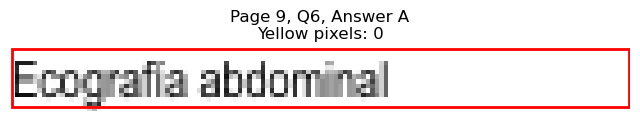

Page 9, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=134.5, y1=518.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 313
Page 9, Q6, B: Yellow percentage: 0.0%


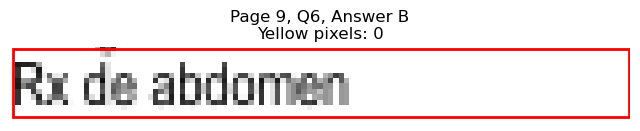

Page 9, Q6 - C: Detected box: x0=327.5, y0=493.4, x1=356.7, y1=506.0
Page 9, Q6, C: Yellow pixels: 942
Page 9, Q6, C: Total non-white pixels: 1041
Page 9, Q6, C: Yellow percentage: 90.5%


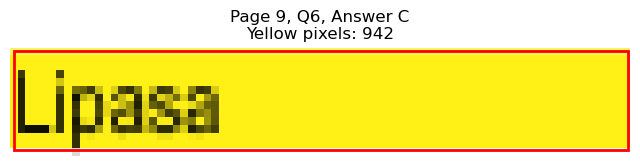

Page 9, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=362.1, y1=518.6
Page 9, Q6, D: Yellow pixels: 85
Page 9, Q6, D: Total non-white pixels: 263
Page 9, Q6, D: Yellow percentage: 32.3%


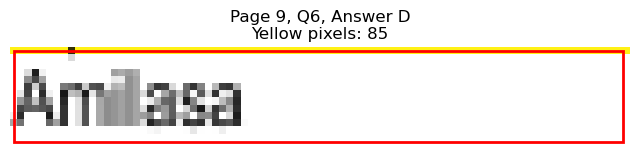


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=556.5, x1=143.5, y1=569.2
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 369
Page 9, Q7, A: Yellow percentage: 0.0%


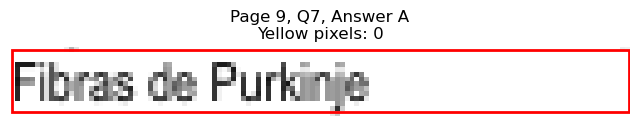

Page 9, Q7 - B: Detected box: x0=68.3, y0=569.1, x1=115.0, y1=581.8
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 225
Page 9, Q7, B: Yellow percentage: 0.0%


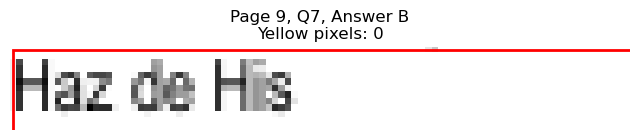

Page 9, Q7 - C: Detected box: x0=327.5, y0=556.5, x1=383.2, y1=569.2
Page 9, Q7, C: Yellow pixels: 107
Page 9, Q7, C: Total non-white pixels: 392
Page 9, Q7, C: Yellow percentage: 27.3%


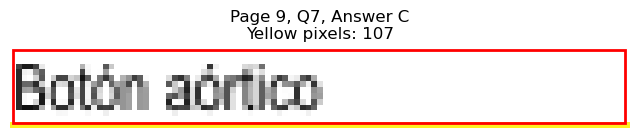

Page 9, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=438.9, y1=581.8
Page 9, Q7, D: Yellow pixels: 1679
Page 9, Q7, D: Total non-white pixels: 2106
Page 9, Q7, D: Yellow percentage: 79.7%


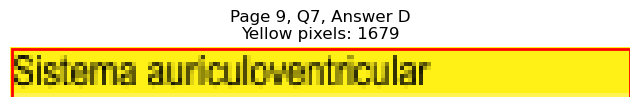


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=154.6, y1=644.9
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 422
Page 9, Q8, A: Yellow percentage: 0.0%


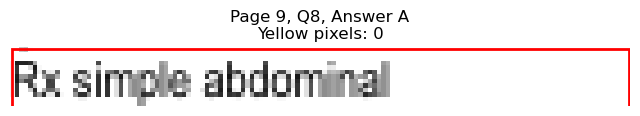

Page 9, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=175.6, y1=657.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 525
Page 9, Q8, B: Yellow percentage: 0.0%


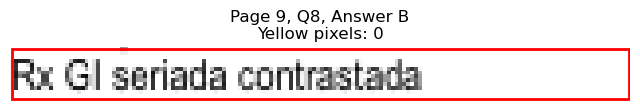

Page 9, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=412.9, y1=644.9
Page 9, Q8, C: Yellow pixels: 1427
Page 9, Q8, C: Total non-white pixels: 1768
Page 9, Q8, C: Yellow percentage: 80.7%


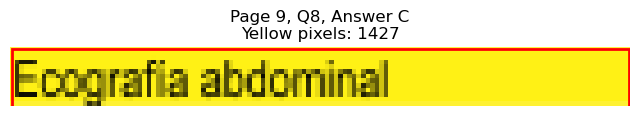

Page 9, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=420.3, y1=657.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 484
Page 9, Q8, D: Yellow percentage: 0.0%


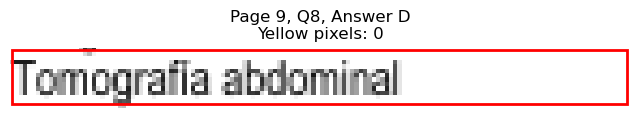


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=708.0, x1=156.6, y1=720.6
Page 9, Q9, A: Yellow pixels: 139
Page 9, Q9, A: Total non-white pixels: 576
Page 9, Q9, A: Yellow percentage: 24.1%


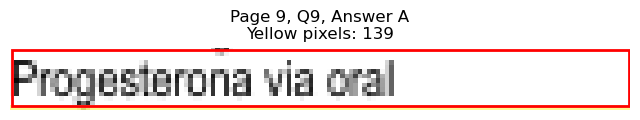

Page 9, Q9 - B: Detected box: x0=68.3, y0=720.6, x1=136.9, y1=733.2
Page 9, Q9, B: Yellow pixels: 1291
Page 9, Q9, B: Total non-white pixels: 1666
Page 9, Q9, B: Yellow percentage: 77.5%


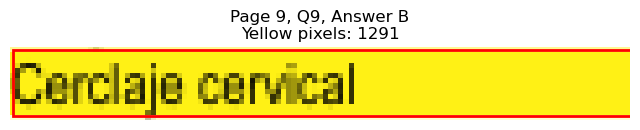

Page 9, Q9 - C: Detected box: x0=327.5, y0=708.0, x1=416.8, y1=720.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 454
Page 9, Q9, C: Yellow percentage: 0.0%


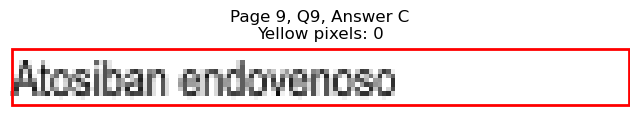

Page 9, Q9 - D: Detected box: x0=327.5, y0=720.6, x1=409.3, y1=733.2
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 439
Page 9, Q9, D: Yellow percentage: 0.0%


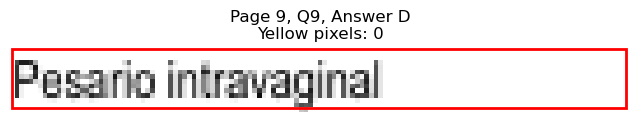


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=125.4, y1=139.9
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 274
Page 10, Q1, A: Yellow percentage: 0.0%


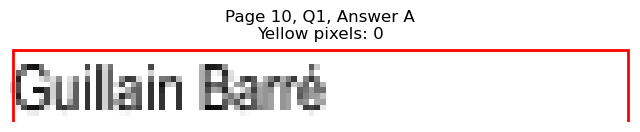

Page 10, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=115.9, y1=152.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 241
Page 10, Q1, B: Yellow percentage: 0.0%


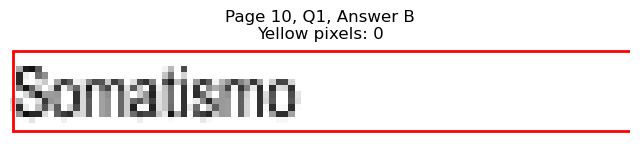

Page 10, Q1 - C: Detected box: x0=327.5, y0=127.2, x1=402.3, y1=139.9
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 416
Page 10, Q1, C: Yellow percentage: 0.0%


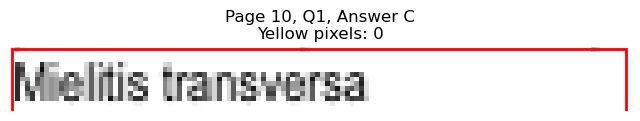

Page 10, Q1 - D: Detected box: x0=327.5, y0=139.9, x1=370.6, y1=152.6
Page 10, Q1, D: Yellow pixels: 1055
Page 10, Q1, D: Total non-white pixels: 1316
Page 10, Q1, D: Yellow percentage: 80.2%


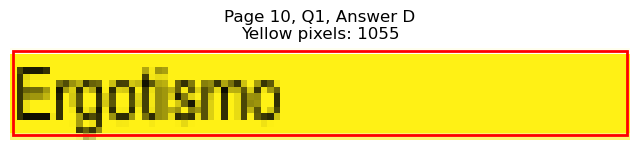


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=65.2, y1=203.0
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 103
Page 10, Q2, A: Yellow percentage: 0.0%


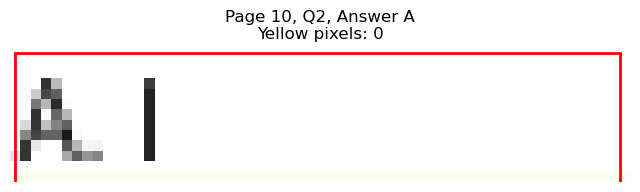

Page 10, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=65.2, y1=215.6
Page 10, Q2, B: Yellow pixels: 719
Page 10, Q2, B: Total non-white pixels: 840
Page 10, Q2, B: Yellow percentage: 85.6%


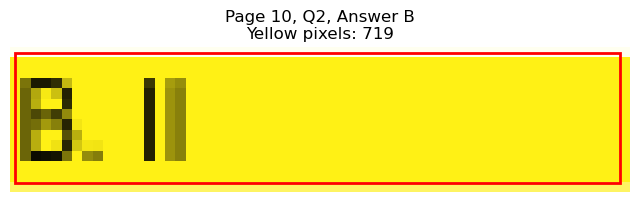

Page 10, Q2 - C: Detected box: x0=327.5, y0=190.3, x1=337.6, y1=203.0
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 50
Page 10, Q2, C: Yellow percentage: 0.0%


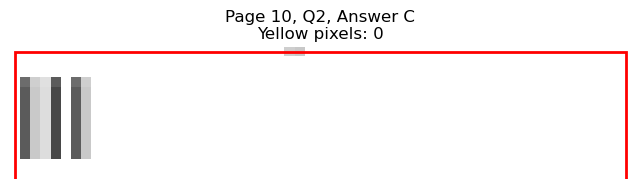

Page 10, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=338.6, y1=215.6
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 42
Page 10, Q2, D: Yellow percentage: 0.0%


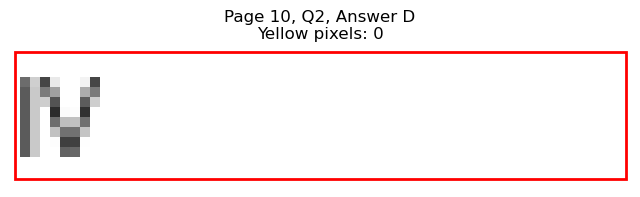


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=127.9, y1=291.5
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 296
Page 10, Q3, A: Yellow percentage: 0.0%


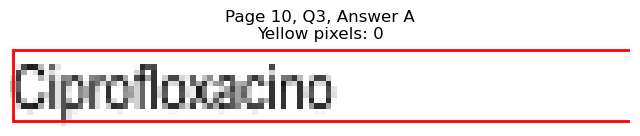

Page 10, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=123.5, y1=304.1
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 281
Page 10, Q3, B: Yellow percentage: 0.0%


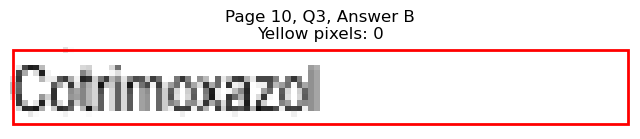

Page 10, Q3 - C: Detected box: x0=327.5, y0=278.8, x1=385.3, y1=291.5
Page 10, Q3, C: Yellow pixels: 109
Page 10, Q3, C: Total non-white pixels: 383
Page 10, Q3, C: Yellow percentage: 28.5%


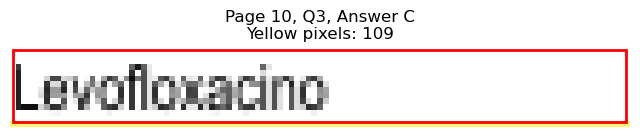

Page 10, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=381.7, y1=304.1
Page 10, Q3, D: Yellow pixels: 1171
Page 10, Q3, D: Total non-white pixels: 1470
Page 10, Q3, D: Yellow percentage: 79.7%


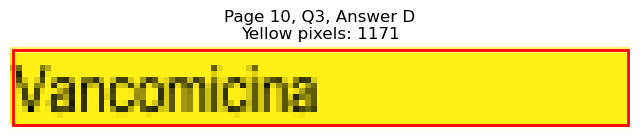


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=65.2, y1=354.6
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 59
Page 10, Q4, A: Yellow percentage: 0.0%


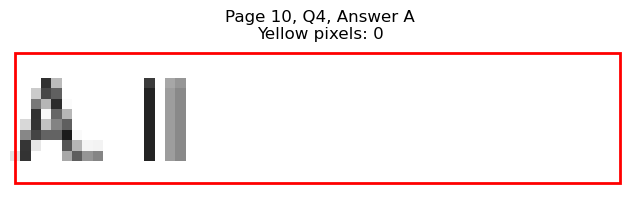

Page 10, Q4 - B: Detected box: x0=68.3, y0=354.5, x1=79.3, y1=367.2
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 36
Page 10, Q4, B: Yellow percentage: 0.0%


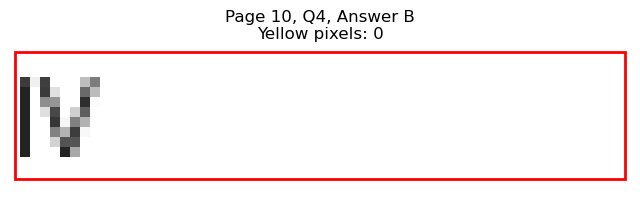

Page 10, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=324.4, y1=354.6
Page 10, Q4, C: Yellow pixels: 733
Page 10, Q4, C: Total non-white pixels: 840
Page 10, Q4, C: Yellow percentage: 87.3%


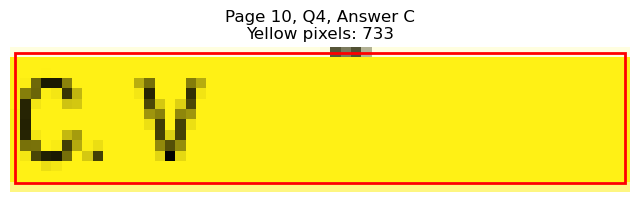

Page 10, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=337.6, y1=367.2
Page 10, Q4, D: Yellow pixels: 61
Page 10, Q4, D: Total non-white pixels: 109
Page 10, Q4, D: Yellow percentage: 56.0%


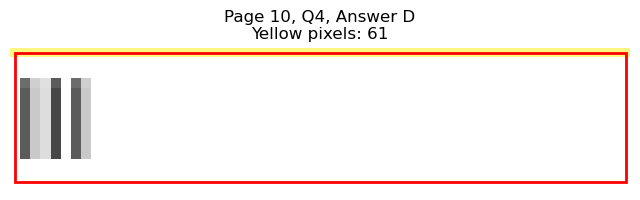


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=100.9, y1=417.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 160
Page 10, Q5, A: Yellow percentage: 0.0%


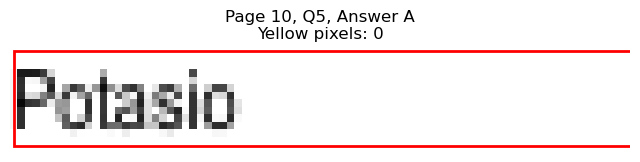

Page 10, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=115.5, y1=430.3
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 229
Page 10, Q5, B: Yellow percentage: 0.0%


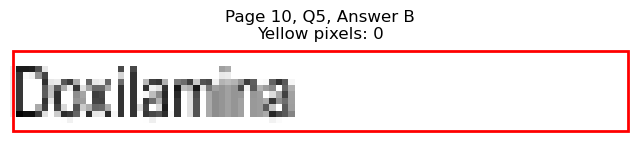

Page 10, Q5 - C: Detected box: x0=327.5, y0=404.9, x1=373.7, y1=417.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 222
Page 10, Q5, C: Yellow percentage: 0.0%


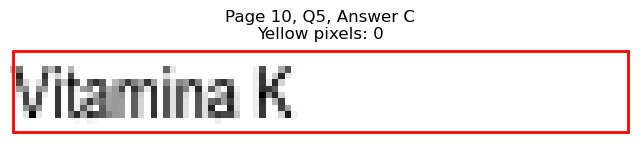

Page 10, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=362.1, y1=430.3
Page 10, Q5, D: Yellow pixels: 907
Page 10, Q5, D: Total non-white pixels: 1204
Page 10, Q5, D: Yellow percentage: 75.3%


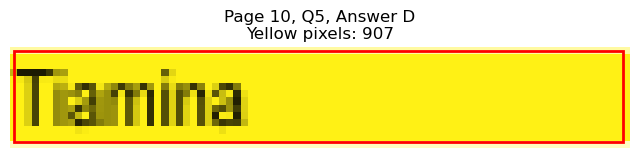


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=189.6, y1=506.0
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 585
Page 10, Q6, A: Yellow percentage: 0.0%


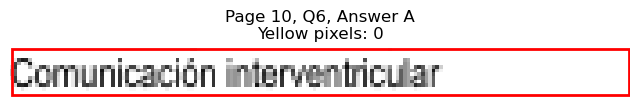

Page 10, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=150.0, y1=518.6
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 405
Page 10, Q6, B: Yellow percentage: 0.0%


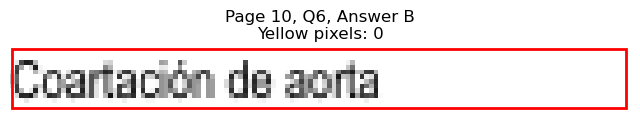

Page 10, Q6 - C: Detected box: x0=327.5, y0=493.4, x1=441.9, y1=506.0
Page 10, Q6, C: Yellow pixels: 1727
Page 10, Q6, C: Total non-white pixels: 2145
Page 10, Q6, C: Yellow percentage: 80.5%


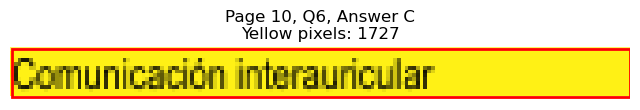

Page 10, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=395.7, y1=518.6
Page 10, Q6, D: Yellow pixels: 119
Page 10, Q6, D: Total non-white pixels: 461
Page 10, Q6, D: Yellow percentage: 25.8%


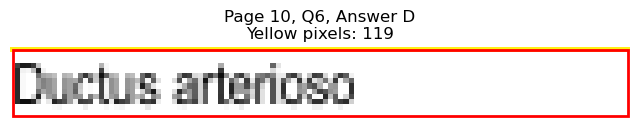


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=85.8, y1=581.8
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 84
Page 10, Q7, A: Yellow percentage: 0.0%


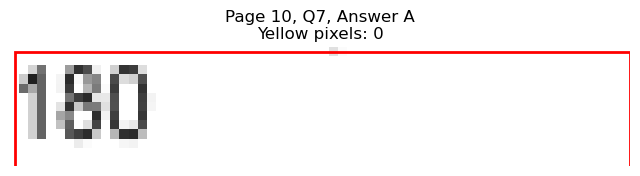

Page 10, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=85.8, y1=594.4
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 81
Page 10, Q7, B: Yellow percentage: 0.0%


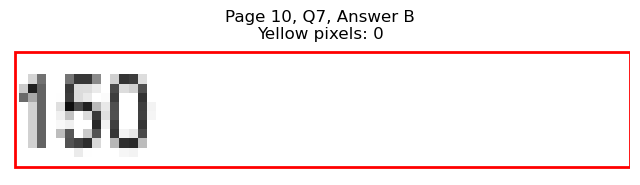

Page 10, Q7 - C: Detected box: x0=327.5, y0=569.1, x1=345.1, y1=581.8
Page 10, Q7, C: Yellow pixels: 842
Page 10, Q7, C: Total non-white pixels: 897
Page 10, Q7, C: Yellow percentage: 93.9%


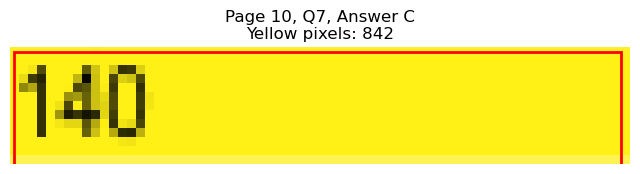

Page 10, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=345.1, y1=594.4
Page 10, Q7, D: Yellow pixels: 69
Page 10, Q7, D: Total non-white pixels: 149
Page 10, Q7, D: Yellow percentage: 46.3%


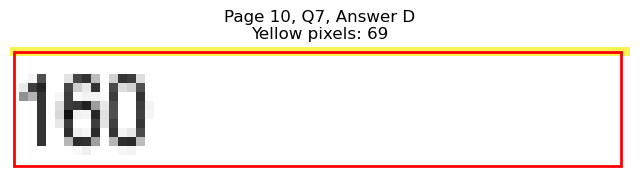


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=632.2, x1=118.0, y1=644.9
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 335
Page 10, Q8, A: Yellow percentage: 0.0%


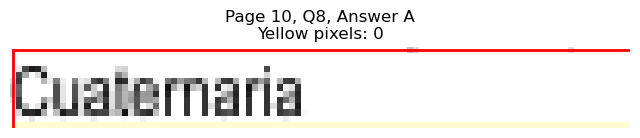

Page 10, Q8 - B: Detected box: x0=68.3, y0=644.9, x1=116.4, y1=657.5
Page 10, Q8, B: Yellow pixels: 1071
Page 10, Q8, B: Total non-white pixels: 1386
Page 10, Q8, B: Yellow percentage: 77.3%


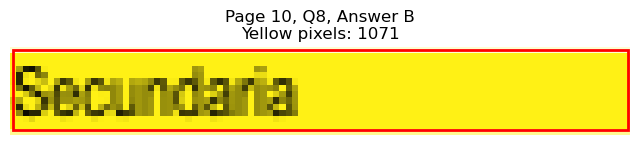

Page 10, Q8 - C: Detected box: x0=327.5, y0=632.2, x1=363.7, y1=644.9
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 169
Page 10, Q8, C: Yellow percentage: 0.0%


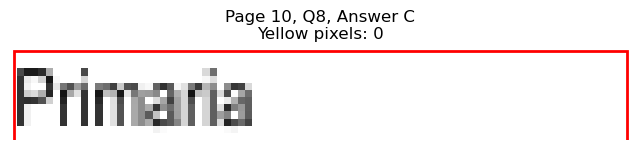

Page 10, Q8 - D: Detected box: x0=327.5, y0=644.9, x1=365.1, y1=657.5
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 189
Page 10, Q8, D: Yellow percentage: 0.0%


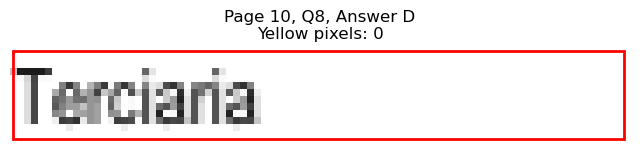


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=695.4, x1=145.0, y1=708.0
Page 10, Q9, A: Yellow pixels: 127
Page 10, Q9, A: Total non-white pixels: 642
Page 10, Q9, A: Yellow percentage: 19.8%


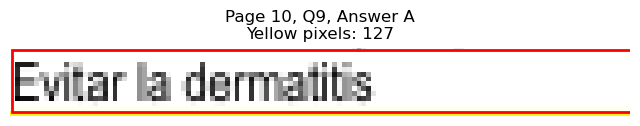

Page 10, Q9 - B: Detected box: x0=68.3, y0=708.0, x1=148.0, y1=720.6
Page 10, Q9, B: Yellow pixels: 1404
Page 10, Q9, B: Total non-white pixels: 1820
Page 10, Q9, B: Yellow percentage: 77.1%


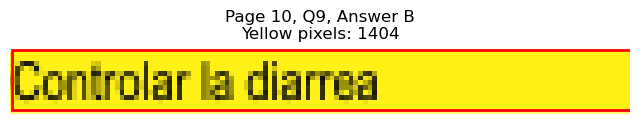

Page 10, Q9 - C: Detected box: x0=327.5, y0=695.4, x1=440.8, y1=708.0
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 588
Page 10, Q9, C: Yellow percentage: 0.0%


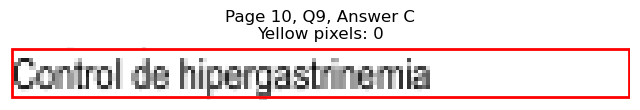

Page 10, Q9 - D: Detected box: x0=327.5, y0=708.0, x1=447.9, y1=720.6
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 610
Page 10, Q9, D: Yellow percentage: 0.0%


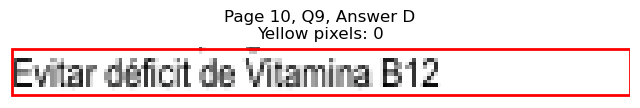


Page 10, Q9 - Selected Answer: B (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=68.3, y0=745.8, x1=80.2, y1=758.4
Page 10, Q10, A: Yellow pixels: 791
Page 10, Q10, A: Total non-white pixels: 882
Page 10, Q10, A: Yellow percentage: 89.7%


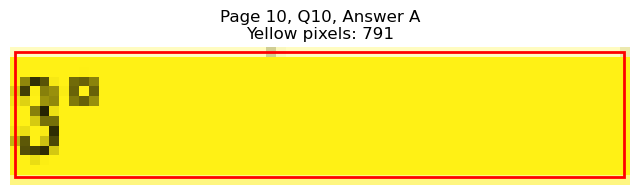

Page 10, Q10 - B: Detected box: x0=68.3, y0=758.5, x1=80.2, y1=771.2
Page 10, Q10, B: Yellow pixels: 63
Page 10, Q10, B: Total non-white pixels: 89
Page 10, Q10, B: Yellow percentage: 70.8%


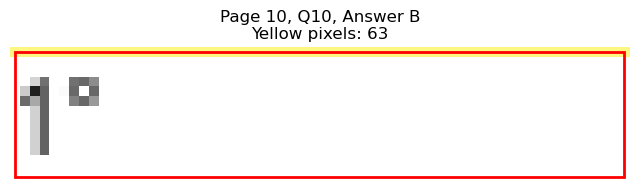

Page 10, Q10 - C: Detected box: x0=327.5, y0=745.8, x1=339.4, y1=758.4
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 40
Page 10, Q10, C: Yellow percentage: 0.0%


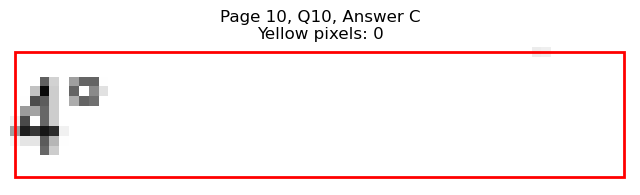

Page 10, Q10 - D: Detected box: x0=327.5, y0=758.5, x1=337.0, y1=771.2
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 35
Page 10, Q10, D: Yellow percentage: 0.0%


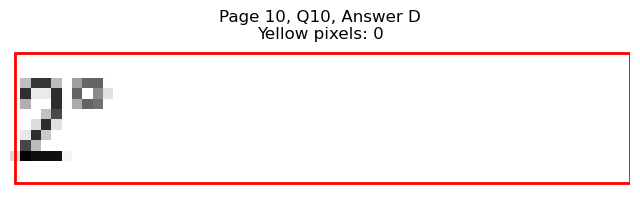


Page 10, Q10 - Selected Answer: A (based on yellow pixel count)





Page 11: Found 6 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=133.0, y1=114.7
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 342
Page 11, Q1, A: Yellow percentage: 0.0%


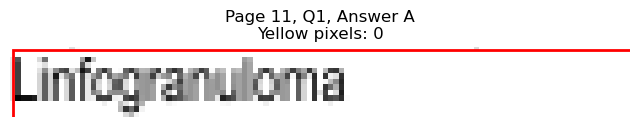

Page 11, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=104.9, y1=127.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 178
Page 11, Q1, B: Yellow percentage: 0.0%


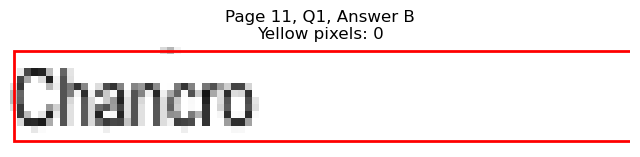

Page 11, Q1 - C: Detected box: x0=327.5, y0=102.0, x1=374.7, y1=114.7
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 324
Page 11, Q1, C: Yellow percentage: 0.0%


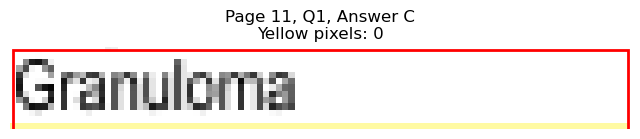

Page 11, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=376.1, y1=127.3
Page 11, Q1, D: Yellow pixels: 1004
Page 11, Q1, D: Total non-white pixels: 1400
Page 11, Q1, D: Yellow percentage: 71.7%


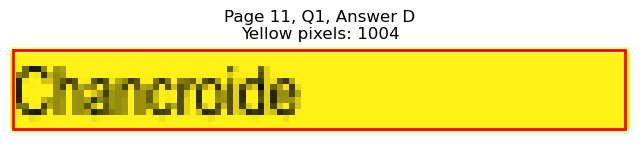


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=109.5, y1=177.8
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 200
Page 11, Q2, A: Yellow percentage: 0.0%


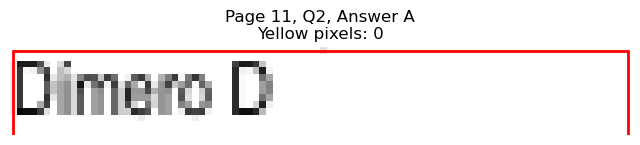

Page 11, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=213.3, y1=190.4
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 700
Page 11, Q2, B: Yellow percentage: 0.0%


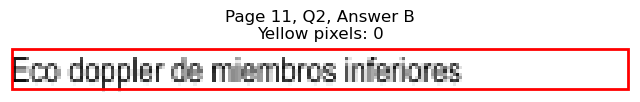

Page 11, Q2 - C: Detected box: x0=327.5, y0=165.1, x1=425.3, y1=177.8
Page 11, Q2, C: Yellow pixels: 1
Page 11, Q2, C: Total non-white pixels: 647
Page 11, Q2, C: Yellow percentage: 0.2%


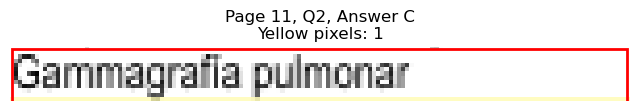

Page 11, Q2 - D: Detected box: x0=327.5, y0=177.7, x1=436.4, y1=190.4
Page 11, Q2, D: Yellow pixels: 1483
Page 11, Q2, D: Total non-white pixels: 2240
Page 11, Q2, D: Yellow percentage: 66.2%


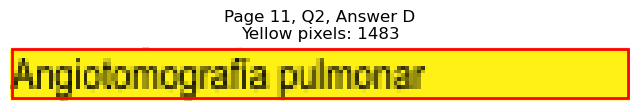


Page 11, Q2 - Selected Answer: D (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=228.3, x1=119.9, y1=240.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 362
Page 11, Q3, A: Yellow percentage: 0.0%


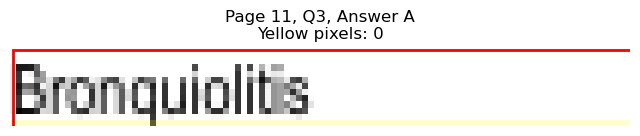

Page 11, Q3 - B: Detected box: x0=68.3, y0=240.9, x1=185.7, y1=253.5
Page 11, Q3, B: Yellow pixels: 1754
Page 11, Q3, B: Total non-white pixels: 2352
Page 11, Q3, B: Yellow percentage: 74.6%


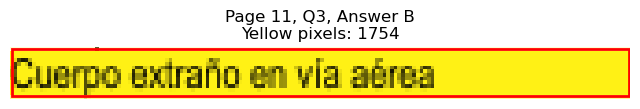

Page 11, Q3 - C: Detected box: x0=327.5, y0=228.3, x1=391.3, y1=240.9
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 335
Page 11, Q3, C: Yellow percentage: 0.0%


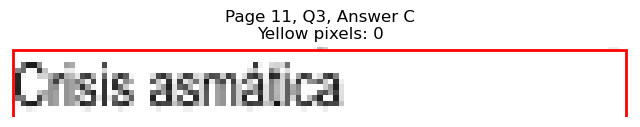

Page 11, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=424.9, y1=253.5
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 490
Page 11, Q3, D: Yellow percentage: 0.0%


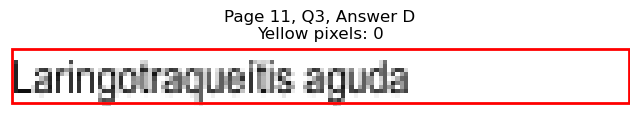


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=291.4, x1=152.5, y1=304.1
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 449
Page 11, Q4, A: Yellow percentage: 0.0%


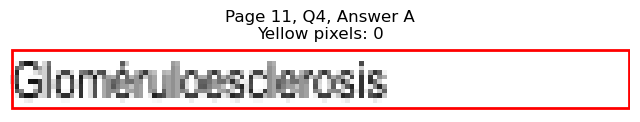

Page 11, Q4 - B: Detected box: x0=68.3, y0=304.0, x1=139.0, y1=316.7
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 377
Page 11, Q4, B: Yellow percentage: 0.0%


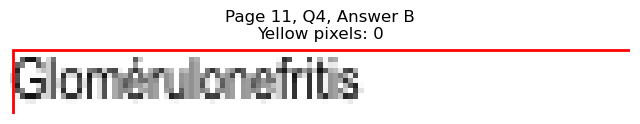

Page 11, Q4 - C: Detected box: x0=327.5, y0=291.4, x1=452.9, y1=304.1
Page 11, Q4, C: Yellow pixels: 1771
Page 11, Q4, C: Total non-white pixels: 2464
Page 11, Q4, C: Yellow percentage: 71.9%


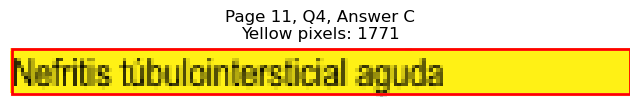

Page 11, Q4 - D: Detected box: x0=327.5, y0=304.0, x1=409.3, y1=316.7
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 557
Page 11, Q4, D: Yellow percentage: 0.0%


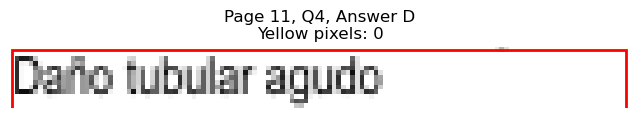


Page 11, Q4 - Selected Answer: C (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=354.5, x1=111.4, y1=367.2
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 258
Page 11, Q5, A: Yellow percentage: 0.0%


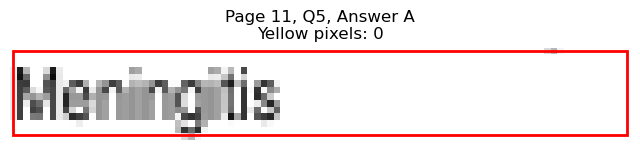

Page 11, Q5 - B: Detected box: x0=68.3, y0=367.1, x1=167.5, y1=379.8
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 497
Page 11, Q5, B: Yellow percentage: 0.0%


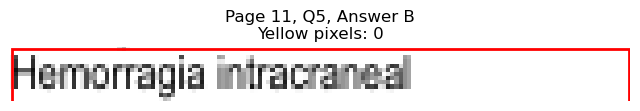

Page 11, Q5 - C: Detected box: x0=327.5, y0=354.5, x1=400.3, y1=367.2
Page 11, Q5, C: Yellow pixels: 124
Page 11, Q5, C: Total non-white pixels: 496
Page 11, Q5, C: Yellow percentage: 25.0%


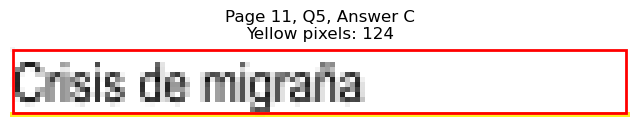

Page 11, Q5 - D: Detected box: x0=327.5, y0=367.1, x1=405.8, y1=379.8
Page 11, Q5, D: Yellow pixels: 1370
Page 11, Q5, D: Total non-white pixels: 1677
Page 11, Q5, D: Yellow percentage: 81.7%


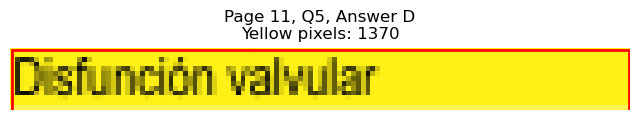


Page 11, Q5 - Selected Answer: D (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=442.8, x1=145.6, y1=455.5
Page 11, Q6, A: Yellow pixels: 1352
Page 11, Q6, A: Total non-white pixels: 1792
Page 11, Q6, A: Yellow percentage: 75.4%


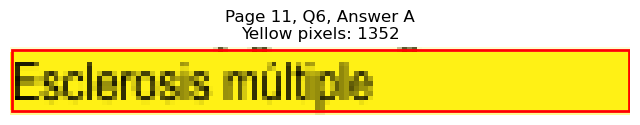

Page 11, Q6 - B: Detected box: x0=68.3, y0=455.5, x1=165.6, y1=468.1
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 492
Page 11, Q6, B: Yellow percentage: 0.0%


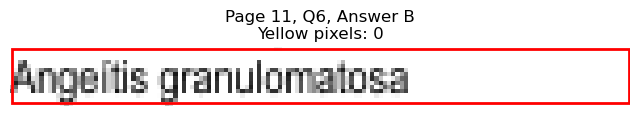

Page 11, Q6 - C: Detected box: x0=327.5, y0=442.8, x1=376.7, y1=455.5
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 257
Page 11, Q6, C: Yellow percentage: 0.0%


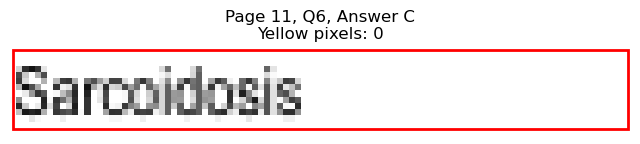

Page 11, Q6 - D: Detected box: x0=327.5, y0=455.5, x1=450.9, y1=468.1
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 644
Page 11, Q6, D: Yellow percentage: 0.0%


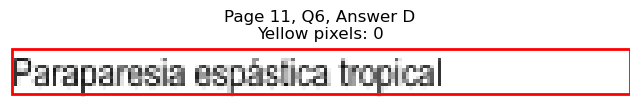


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Niño de 6 años, presenta hace 7 días rinorrea ...
1   Varón de 77 años, fumador, acude por presentar...
2   Mujer de 46 años, acude por dolor abdominal, n...
3   Primigesta de 38 semanas, acude por presentar ...
4   En el ámbito sanitario de una red integrada de...
..                                                ...
95  Varón de 76 años, en reposo post operatorio de...
96  Niño de 2 años previamente sano, es traído a e...
97  Mujer de 51 años, cursa con recidiva de cáncer...
98  Escolar de 12 años con derivación ventrículo p...
99  Varón de 38 años, acude por presentar parestes...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                       Microbiología   
1                                              Normal   
2                                              Severa   
3                       Evolución espontánea de parto   
4   Implementar nuevo servicio de cuidados intensivos   
..                                                ...   
95                                           Dímero D   
96                                      Bronquiolitis   
97                                Gloméruloesclerosis   
98                                         Meningitis   
99                                Esclerosis múltiple   

                                             option_B  \
0                                          Tomografía   
1                                         Obstructivo   
2                                            Moderada   
3                            Cesárea a las 40 semanas   
4   Incrementar el requerimiento de medicamentos e...   
..                                                ...   
95                 Eco doppler de miembros inferiores   
96                        Cuerpo extraño en vía aérea   
97                                  Glomérulonefritis   
98                            Hemorragia intracraneal   
99                             Angeítis granulomatosa   

                                        option_C  \
0                                      Serología   
1                                    Restrictivo   
2                                          Grave   
3                          Terminar la gestación   
4   Solicitar contrato de personal especializado   
..                                           ...   
95                          Gammagrafía pulmonar   
96                               Crisis asmática   
97             Nefritis túbulointersticial aguda   
98                             Crisis de migraña   
99                                   Sarcoidosis   

                                             option_D  
0                                         Radiografía  
1                                               Mixto  
2                                                Leve  
3                   Control en una semana con doppler  
4   Acción intersectorial y abordaje de los determ...  
..                                                ...  
95                           Angiotomografía pulmonar  
96                            Laringotraqueítis aguda  
97                                 Daño tubular agudo  
98                                Disfunción valvular  
99                     Paraparesia espástica tropical  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               B
3               C
4               D
..            ...
95              D
96              B
97              C
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Niño de 6 años, presenta hace 7 días rinorrea ...   
1   Varón de 77 años, fumador, acude por presentar...   
2   Mujer de 46 años, acude por dolor abdominal, n...   
3   Primigesta de 38 semanas, acude por presentar ...   
4   En el ámbito sanitario de una red integrada de...   
..                                                ...   
95  Varón de 76 años, en reposo post operatorio de...   
96  Niño de 2 años previamente sano, es traído a e...   
97  Mujer de 51 años, cursa con recidiva de cáncer...   
98  Escolar de 12 años con derivación ventrículo p...   
99  Varón de 38 años, acude por presentar parestes...   

                                             option_A  \
0                                       Microbiología   
1                                              Normal   
2                                              Severa   
3                       Evolución espontánea de parto   
4   Implementar nuevo servicio de cuidados intensivos   
..                                                ...   
95                                           Dímero D   
96                                      Bronquiolitis   
97                                Gloméruloesclerosis   
98                                         Meningitis   
99                                Esclerosis múltiple   

                                             option_B  \
0                                          Tomografía   
1                                         Obstructivo   
2                                            Moderada   
3                            Cesárea a las 40 semanas   
4   Incrementar el requerimiento de medicamentos e...   
..                                                ...   
95                 Eco doppler de miembros inferiores   
96                        Cuerpo extraño en vía aérea   
97                                  Glomérulonefritis   
98                            Hemorragia intracraneal   
99                             Angeítis granulomatosa   

                                        option_C  \
0                                      Serología   
1                                    Restrictivo   
2                                          Grave   
3                          Terminar la gestación   
4   Solicitar contrato de personal especializado   
..                                           ...   
95                          Gammagrafía pulmonar   
96                               Crisis asmática   
97             Nefritis túbulointersticial aguda   
98                             Crisis de migraña   
99                                   Sarcoidosis   

                                             option_D correct_answer  
0                                         Radiografía              D  
1                                               Mixto              B  
2                                                Leve              B  
3                   Control en una semana con doppler              C  
4   Acción intersectorial y abordaje de los determ...              D  
..                                                ...            ...  
95                           Angiotomografía pulmonar              D  
96                            Laringotraqueítis aguda              B  
97                                 Daño tubular agudo              C  
98                                Disfunción valvular              D  
99                     Paraparesia espástica tropical              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD A.csv
